This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import IPython.display
import subprocess as sb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import gc

#### Download Data

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
#!pip install pandas==1.1.5

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
def download_from_kaggle():
      sb.run(['pip', 'install', 'kaggle', '--upgrade', '-q'])
      sb.run(['mkdir', '-p', '/root/.kaggle'])
      sb.run(['cp', './kaggle.json', '/root/.kaggle/'])
      sb.run(['kaggle', 'competitions', 'download', '-q', 'competitive-data-science-predict-future-sales', '-p', './data/'])

download_from_kaggle()


In [ ]:
%%time
train = pd.read_csv('./data/sales_train.csv.zip', parse_dates=['date'], dayfirst=True)
items = pd.read_csv('./data/items.csv.zip')
shops = pd.read_csv('./data/shops.csv')
cats = pd.read_csv('./data/item_categories.csv')

print('Original data type is:\n',train.dtypes)

Original data type is:
 date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object
CPU times: user 1.92 s, sys: 156 ms, total: 2.08 s
Wall time: 2.08 s


In [ ]:
train.shape

(2935849, 6)

In [ ]:
#train[train.date.map(lambda x:x.year>=2014)]

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [ ]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [ ]:
train.shape

(2935847, 6)

In [ ]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [ ]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

# we wont make use of item names. So drop that columns as of now.
items.drop(labels='item_name', axis=1, inplace=True)


In [ ]:
# Remove possible duplicates
train.drop_duplicates(inplace=True)
items.drop_duplicates(inplace=True)
shops.drop_duplicates(inplace=True)
cats.drop_duplicates(inplace=True)

In [ ]:
# 6 duplicate data removed!
train.shape

(2935841, 6)

In [ ]:
# we wont need daily date column as we will work with month number instead
train.drop('date', axis=1, inplace=True)
#train = train[train.date_block_num >11]

In [ ]:
display(train.head())
print(train.shape)

date_block_num  shop_id  item_id  item_price  item_cnt_day
0               0       59    22154      999.00           1.0
1               0       25     2552      899.00           1.0
2               0       25     2552      899.00          -1.0
3               0       25     2554     1709.05           1.0
4               0       25     2555     1099.00           1.0

(2935841, 5)


## Dataset Creator:

In [ ]:
def yer(x):
    if x<12: return 2013
    elif x<24: return 2014
    else: return 2015


def prep_dataset(data, lag_length, lag_name, lags=None, with_label=True):
    '''Creates lags of given names and a series of rows of data, each aiming
    to target a label, which is item count in a month.'''

    columns = []
    # Column names
    lag_title = ['{}_{}'.format(lag_name, i) for i in range(lag_length,0,-1)]
    columns.extend(['shop_id', 'item_id'])
    columns.extend(lag_title)
    columns.extend(['month_of_pred', 'year_of_pred'])
    if with_label: columns.extend(['label'])
    prep_data = pd.DataFrame()
    length = data.shape[0]
    n = length - lag_length
    for i in range(0,n):
        df1 = pd.DataFrame(data.T.reset_index()[['shop_id', 'item_id']].values, columns=['shop_id', 'item_id'])
        # Lag features are attached to (item_id, shop_id) pairs
        df1 = pd.concat([df1, pd.DataFrame(data[length-1-i-lag_length: length-1-i].T.values, dtype='float16')], axis=1, ignore_index=True)
        # Create month and year of the label being predicted - attach it to df1
        df2 = pd.DataFrame({
                            'month_of_pred': [data[length-i-1: length-i].index.values[0]%12+1]*df1.shape[0],
                            'year_of_pred': [yer(data[length-i-1: length-i].index.values[0])]*df1.shape[0]
                            }, dtype='int16')
        # Add label only for item_cnt records
        if with_label:
            df3 = pd.DataFrame({'label':data[length-i-1: length-i].T.values.reshape(-1)},dtype='float16')
            prep_data = prep_data.append(pd.concat([df1, df2, df3], axis=1, ignore_index=True))
        else:
            prep_data = prep_data.append(pd.concat([df1, df2], axis=1, ignore_index=True))

    prep_data.columns = columns
    if lags:
       drop = ['{}_{}'.format(lag_name, i) for i in lags]
       prep_data.drop(drop, axis=1, inplace=True)
    return prep_data

# def prep_dataset(data, window_length, lag_name, with_label=True):
#     columns = []
#     lag_title = ['{}_{}'.format(lag_name, i+1) for i in range(window_length)]
#     columns.extend(['shop_id', 'item_id'])
#     columns.extend(lag_title)
#     columns.extend(['month_of_pred', 'year_of_pred'])
#     if with_label: columns.extend(['label'])
#     prep_data = pd.DataFrame()
#     length = data.shape[0]
#     n = length - window_length
#     for i in range(0,n):
#         df1 = pd.DataFrame(data.T.reset_index()[['shop_id', 'item_id']].values, columns=['shop_id', 'item_id'])
#         df1 = pd.concat([df1, pd.DataFrame(data[length-1-i-window_length: length-1-i].T.values, dtype='float16')], axis=1, ignore_index=True)
#         df2 = pd.DataFrame({
#                             'month_of_pred': [data[length-i-1: length-i].index.values[0]%12+1]*df1.shape[0],
#                             'year_of_pred': [yer(data[length-i-1: length-i].index.values[0])]*df1.shape[0]
#                             }, dtype='int16')
#         if with_label:
#             df3 = pd.DataFrame({'label':data[length-i-1: length-i].T.values.reshape(-1)},dtype='float16')
#             prep_data = prep_data.append(pd.concat([df1, df2, df3], axis=1, ignore_index=True))
#         else:
#             prep_data = prep_data.append(pd.concat([df1, df2], axis=1, ignore_index=True))
#     prep_data.columns = columns
#     return prep_data


def pivot(data, values, index, columns):
    return pd.pivot_table(data,
                      values=[values],
                      index=index,
                      columns=columns,)[values]

In [ ]:
lag_length = 12
train = train.append(pd.DataFrame([[34, 25, 2552, 0.0, 0.0]], columns=list(train.columns)))


# Building the base data for item count sale records - We downsample by aggregating target records to the monthly level

# Clip the sale record as instructed by competition evaluation rule
data_cnt = train.groupby(['date_block_num','shop_id', 'item_id'])['item_cnt_day'].sum().clip(0,20)
data_cnt = data_cnt.reset_index()

data = pivot(data_cnt, 'item_cnt_day', 'date_block_num', ['shop_id', 'item_id'])
data = data.fillna(0.0)
data_cnt = data.stack(['item_id', 'shop_id']).reset_index()
data_cnt.rename(columns={0: 'item_cnt_month'}, inplace=True)

data_cnt = data_cnt.merge(items, how='left', on='item_id')
data_cnt = data_cnt.merge(shops, how='left', on='shop_id')
data_cnt = data_cnt.merge(cats, how='left', on='item_category_id')

# We now start to gradually build the dataset from low to high granularity

# Dataset I - Item Count-monthly
data = pivot(data_cnt, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
Merged = prep_dataset(data, lag_length, lag_name='cnt_shop_item', with_label=True)

Merged = pd.merge(Merged, items, how='left', on='item_id')
Merged = pd.merge(Merged, cats, how='left', on='item_category_id')
Merged = pd.merge(Merged, shops, how='left', on='shop_id')

# Downcast to save memory
Merged = Merged.astype({'shop_id': 'int8',
                        'item_id': 'int16',
                        'month_of_pred':'int8',
                        'year_of_pred':'int16',
                        'label':'float16',
                        'item_category_id':'int8',
                        'city_code':'int8',
                        'subtype_code':'int8',
                        'type_code':'int8'
                        })

# Part II
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
data = data.groupby(['date_block_num']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date', with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part III
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'item_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_item', with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part IV
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_shop', with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part V
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'item_category_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_item_cat', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part VI
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_shop_cat', lags=[4,5,6,7,8,9], with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part VII
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'type_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id', 'type_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_shop_cat_type', lags=[4,5,6,7,10,11], with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part VIII
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'subtype_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id', 'subtype_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_shop_cat_subtype', lags=[5,6,7,8,9,10,11], with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part IX
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'city_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_city', lags= [5,6,7,8,9,10,11,12], with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part X
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'item_id', 'city_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_item_city', lags=[5,6,7,8,9,10,11,12], with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part XI
# data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
# data = data.groupby(['date_block_num', 'item_id', 'city_code']).transform('mean').reset_index()
# data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
# data = prep_dataset(data, lag_length, lag_name='cnt_date_item_city', with_label=False)

# Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part XII

data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'type_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'type_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_type', lags=[3,4], with_label=False)

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part XIII

data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'subtype_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'subtype_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
data = prep_dataset(data, lag_length, lag_name='cnt_date_subtype', with_label=False)

del data_cnt

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Base data for price records

data_price = train.groupby(['date_block_num','shop_id', 'item_id'])['item_price'].mean() #Average price in month at item-shop level
data_price = data_price.reset_index()
data = pivot(data_price, 'item_price', 'date_block_num', ['shop_id', 'item_id'])
data = data.ffill()
data = data.bfill()
data_price = data.stack(['item_id', 'shop_id']).reset_index()
data_price = data_price.merge(items, how='left', on='item_id')
data_price.rename(columns={0:'avg_price_month'}, inplace=True)

# Release some memory
del train
del items
del shops
del cats

# Part XIV

data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
data = data.groupby(['item_id']).transform('mean').reset_index()
avg_item_price_whole_data = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])

data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
data = data.groupby(['date_block_num', 'item_id']).transform('mean').reset_index()
avg_item_price_monthly = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])

data = (avg_item_price_monthly - avg_item_price_whole_data)/avg_item_price_whole_data

del avg_item_price_monthly
del avg_item_price_whole_data
gc.collect()

data = prep_dataset(data, lag_length, lag_name='Avg_price_item', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part XV

data = data_price.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['avg_price_month']
data = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).transform('sum').reset_index()
price_cat_shop = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])

data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
data = data.groupby(['date_block_num', 'shop_id', 'item_id']).transform('mean').reset_index()
price_item_shop = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])
data = price_item_shop/price_cat_shop

del price_cat_shop

data = prep_dataset(data, lag_length, lag_name='item_price_percnt',lags=[5,10,11], with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Part XVI

diff_price = price_item_shop - price_item_shop.shift(1)
data = diff_price[1:]/price_item_shop.shift(1)
data = data.fillna(0.0)
data = prep_dataset(data, lag_length, lag_name='item_price_discount', lags=[2,3,4,5,6,7,8,9,10,11,12], with_label=False)

del diff_price
del data_price
del price_item_shop
gc.collect()

Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

#Add days in the month of prediction- and, number of month of prediction
my = pd.concat([pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2013]*12}),
                pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2014]*12}),
                pd.DataFrame({'month_of_pred': np.arange(1,12),'year_of_pred' : [2015]*11})],
                              axis=0, ignore_index=True)
my['days'] = my.apply(lambda x:pd.Timestamp(x[1],x[0],1,0).days_in_month, axis=1)
my = my.reset_index().rename(columns={'index':'month_num_pred'},)
Merged = pd.merge(Merged, my, how='left', on=['month_of_pred', 'year_of_pred'])

drop = ['type_code', 'year_of_pred']
Merged.drop(drop, axis=1, inplace=True)




In [ ]:
my = pd.concat([pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2013]*12}),
                pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2014]*12}),
                pd.DataFrame({'month_of_pred': np.arange(1,12),'year_of_pred' : [2015]*11})],
                              axis=0, ignore_index=True)
my['days'] = my.apply(lambda x:pd.Timestamp(x[1],x[0],1,0).days_in_month, axis=1)
my = my.reset_index().rename(columns={'index':'month_num_pred'},)
my

month_num_pred  month_of_pred  year_of_pred  days
0                0              1          2013    31
1                1              2          2013    28
2                2              3          2013    31
3                3              4          2013    30
4                4              5          2013    31
5                5              6          2013    30
6                6              7          2013    31
7                7              8          2013    31
8                8              9          2013    30
9                9             10          2013    31
10              10             11          2013    30
11              11             12          2013    31
12              12              1          2014    31
13              13              2          2014    28
14              14              3          2014    31
15              15              4          2014    30
16              16              5          2014    31
17              17              6          2014    30
18              18              7          2014    31
19              19              8          2014    31
20              20              9          2014    30
21              21             10          2014    31
22              22             11          2014    30
23              23             12          2014    31
24              24              1          2015    31
25              25              2          2015    28
26              26              3          2015    31
27              27              4          2015    30
28              28              5          2015    31
29              29              6          2015    30
30              30              7          2015    31
31              31              8          2015    31
32              32              9          2015    30
33              33             10          2015    31
34              34             11          2015    30

In [ ]:
Merged.month_num_pred.unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 11])

### Founding the base data

Before we process the data any further, we add one record for month number 35, with any arbitrary (item_id, shop_id) and any price or item_cnt_day values. The values will not matter as they wont be used anyways. When we later pivot the train table, this single record automatically gets expanded to the whole set of (item_id, shop_id) pairs existed in the train table for the month number 35. This part of data will form our test set later.  

In [ ]:
train = train.append(pd.DataFrame([[34, 25, 2552, 0.0, 0.0]], columns=list(train.columns)))
train.shape

(2935842, 5)

In [ ]:
data_cnt = train.groupby(['date_block_num','shop_id', 'item_id'])['item_cnt_day'].sum().clip(0,20)
data_cnt = data_cnt.reset_index()

In [ ]:
data = pivot(data_cnt, 'item_cnt_day', 'date_block_num', ['shop_id', 'item_id'])
data = data.fillna(0.0)
data_cnt = data.stack(['item_id', 'shop_id']).reset_index()
data_cnt.rename(columns={0: 'item_cnt_month'}, inplace=True)

In [ ]:
display(data_cnt.head())
print('Data shape is: ',data_cnt.shape)
print('The number of (item_id,shop_id) pairs is: ', sum(data_cnt.date_block_num==0))

date_block_num  item_id  shop_id  item_cnt_month
0               0        0       54             0.0
1               0        1       55             0.0
2               0        2       54             0.0
3               0        3       54             0.0
4               0        4       54             0.0

Data shape is:  (14844305, 4)
The number of (item_id,shop_id) pairs is:  424123


In [ ]:
#data_cnt[data_cnt.date_block_num==35]

In [ ]:
data_cnt = data_cnt.merge(items, how='left', on='item_id')
data_cnt = data_cnt.merge(shops, how='left', on='shop_id')
data_cnt = data_cnt.merge(cats, how='left', on='item_category_id')

In [ ]:
print('Data shape is: ',data_cnt.shape)
print('The number of (item_id,shop_id) pairs is: ', sum(data_cnt.date_block_num==0))

Data shape is:  (14844305, 8)
The number of (item_id,shop_id) pairs is:  424123


As you can see, 424123 more rows was added to the data for month 35.

## Dataset I

In [ ]:
data = pivot(data_cnt, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

In [ ]:
data.shape

(35, 424123)

In [ ]:
Merged = prep_dataset(data, 12, lag_name='cnt_shop_item',lags=[1,4,9], with_label=True)

In [ ]:
#Merged.head()

shop_id  item_id  cnt_shop_item_12  ...  month_of_pred  year_of_pred  label
0        0       30               0.0  ...             11          2015    0.0
1        0       31               0.0  ...             11          2015    0.0
2        0       32               0.0  ...             11          2015    0.0
3        0       33               0.0  ...             11          2015    0.0
4        0       35               0.0  ...             11          2015    0.0

[5 rows x 14 columns]

In [ ]:
Merged = pd.merge(Merged, items, how='left', on='item_id')
Merged = pd.merge(Merged, cats, how='left', on='item_category_id')
Merged = pd.merge(Merged, shops, how='left', on='shop_id')

In [ ]:
Merged = Merged.astype({'shop_id': 'int8',
                        'item_id': 'int16',
                        'month_of_pred':'int8',
                        'year_of_pred':'int16',
                        'label':'float16',
                        'item_category_id':'int8',
                        'city_code':'int8',
                        'subtype_code':'int8',
                        'type_code':'int8'
                        })

In [ ]:
Merged = pd.merge(Merged, my, how='left', on=['month_of_pred', 'year_of_pred'])

## Dataset II

In [ ]:
#%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
data = data.groupby(['date_block_num']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])


In [ ]:
data.shape

(35, 424123)

In [ ]:
data = prep_dataset(data, 6, lag_name='cnt_date', with_label=False)

TypeError: ignored

In [ ]:
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

In [ ]:
Merged.head()

shop_id  item_id  cnt_shop_item_1  ...  cnt_date_4  cnt_date_5  cnt_date_6
0        0       30              0.0  ...     0.14563    0.135986    0.145142
1        0       31              0.0  ...     0.14563    0.135986    0.145142
2        0       32              0.0  ...     0.14563    0.135986    0.145142
3        0       33              0.0  ...     0.14563    0.135986    0.145142
4        0       35              0.0  ...     0.14563    0.135986    0.145142

[5 rows x 21 columns]

In [ ]:
#Merged = Merged.astype({'cnt_date_{}'.format(i+1):'float16' for i in range(6)})
#Merged.dtypes

## Dataset III

In [ ]:
# arrays = [
#         ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
#         ["doo", "doo", "bee", "bee", "bop", "bop", "bop", "bop"],
#         ["one", "two", "one", "two", "one", "two", "one", "two"],
#     ]
# index = pd.MultiIndex.from_arrays(arrays, names=["first", "second", "third"])
# s = pd.Series(np.random.randn(8), index=index)
# s
# s.groupby(['first', 'second']).transform('sum')

In [ ]:
#%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'item_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])


In [ ]:
data = prep_dataset(data, window_length=6, lag_name='cnt_date_item', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
#Merged = Merged.astype({'cnt_date_item_{}'.format(i+1):'float16' for i in range(6)})

In [ ]:
#Merged.dtypes

## Dataset IV

In [ ]:
#%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
# data = pd.pivot_table(data,
#                       values=['item_cnt_day'],
#                       index='date_block_num',
#                       columns=['shop_id', 'item_id'],)['item_cnt_day']

In [ ]:
data = prep_dataset(data, window_length=6, lag_name='cnt_date_shop', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
#Merged = Merged.astype({'cnt_date_shop_{}'.format(i+1):'float16' for i in range(6)})

In [ ]:
#Merged.head()

## Dataset V

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'item_category_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

# data = pd.pivot_table(data,
#                       values=['item_cnt_day'],
#                       index='date_block_num',
#                       columns=['shop_id', 'item_id'],)['item_cnt_day']

In [ ]:
data = prep_dataset(data, window_length=6, lag_name='cnt_date_item_cat', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
#Merged = Merged.astype({'cnt_date_item_cat_{}'.format(i+1):'float16' for i in range(6)})

In [ ]:
#Merged

## Dataset VI

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])


In [ ]:
data.shape

In [ ]:
data = prep_dataset(data, window_length=6, lag_name='cnt_date_shop_cat', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
#Merged = Merged.astype({'cnt_date_shop_cat_{}'.format(i+1):'float16' for i in range(6)})

In [ ]:
#Merged.dtypes

## Features realted to names!

## Dataset *VII*

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'type_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id', 'type_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])


In [ ]:
data = prep_dataset(data, window_length=6, lag_name='cnt_date_shop_cat_type', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
#Merged = Merged.astype({'cnt_shop_cat_type_{}'.format(i+1):'float16' for i in range(6)})

## Dataset *VIII*

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'subtype_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'shop_id', 'subtype_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])


In [ ]:
data = prep_dataset(data, window_length=6, lag_name='cnt_date_shop_subtype', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
#Merged = Merged.astype({'cnt_date_shop_cat_{}'.format(i+1):'float16' for i in range(6)})

## Dataset IX

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'city_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

CPU times: user 16.5 s, sys: 116 ms, total: 16.6 s
Wall time: 16.6 s


In [ ]:
data = prep_dataset(data, 6, lag_name='cnt_date_city', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

## Dataset X

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'item_id', 'city_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

CPU times: user 19.2 s, sys: 336 ms, total: 19.6 s
Wall time: 19.5 s


In [ ]:
data = prep_dataset(data, 6, lag_name='cnt_date_item_city', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

# Dataset XI

In [ ]:
# %%time
# data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
# data = data.groupby(['date_block_num', 'item_id', 'city_code']).transform('mean').reset_index()
# data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

In [ ]:
# data = prep_dataset(data, window_length=6, lag_name='cnt_date_item_city', with_label=False)
# Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])


## Dataset XII

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'type_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'type_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

CPU times: user 15.9 s, sys: 103 ms, total: 16 s
Wall time: 15.9 s


In [ ]:
data = prep_dataset(data, 6, lag_name='cnt_date_type', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])


## Dataset XIII

In [ ]:
%%time
data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'subtype_code'])['item_cnt_month']
data = data.groupby(['date_block_num', 'subtype_code']).transform('mean').reset_index()
data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])

CPU times: user 16.2 s, sys: 87.8 ms, total: 16.3 s
Wall time: 16.2 s


In [ ]:
data.shape

(35, 424123)

In [ ]:
data = prep_dataset(data, 6, lag_name='cnt_date_subtype', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])


In [ ]:
del data_cnt
gc.collect()

239

In [ ]:
#Merged.dtypes

In [ ]:
print('So far, good!')

So far, good!



 # Dataset: Base data for price related features


In [ ]:
data_price = train.groupby(['date_block_num','shop_id', 'item_id'])['item_price'].mean() #Average price in month at item-shop level
data_price = data_price.reset_index()

In [ ]:
#data_price

In [ ]:
data = pivot(data_price, 'item_price', 'date_block_num', ['shop_id', 'item_id'])
data = data.ffill()
data = data.bfill()
data_price = data.stack(['item_id', 'shop_id']).reset_index()
data_price = data_price.merge(items, how='left', on='item_id')
data_price.rename(columns={0:'avg_price_month'}, inplace=True)

In [ ]:
del train
del items
del shops
del cats

# Datasets: prices at different granularity

In [ ]:
%%time
# Price at item_id granularity in whole data
data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
data = data.groupby(['item_id']).transform('mean').reset_index()
avg_item_price_whole_data = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])
# data = pd.pivot_table(data,
#                       values=['item_price'],
#                       index='date_block_num',
#                       columns=['shop_id', 'item_id'],)


CPU times: user 14.9 s, sys: 111 ms, total: 15 s
Wall time: 14.9 s


In [ ]:
#avg_item_price_whole_data

In [ ]:
%%time
# Price at month-item_id granularity
data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
data = data.groupby(['date_block_num', 'item_id']).transform('mean').reset_index()
avg_item_price_monthly = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])

# data = pd.pivot_table(data,
#                       values=['item_price'],
#                       index='date_block_num',
#                       columns=['shop_id', 'item_id'],)


CPU times: user 15.2 s, sys: 82.2 ms, total: 15.3 s
Wall time: 15.2 s


## Dataset XIV - Price

In [ ]:
data = (avg_item_price_monthly - avg_item_price_whole_data)/avg_item_price_whole_data
#data

In [ ]:
del avg_item_price_monthly
del avg_item_price_whole_data
gc.collect()

76

In [ ]:
data = prep_dataset(data, 6, lag_name='Avg_price_item', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])


## DatasetII - Price

In [ ]:
data = data_price.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['avg_price_month']
data = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).transform('sum').reset_index()
data = pivot(data, 'avg_price_month', 'date_block_num', columns=['shop_id', 'item_id'])
# data = pd.pivot_table(data,
#                       values=['item_price'],
#                       index='date_block_num',
#                       columns=['shop_id', 'item_id'],)
price_cat_shop = data

In [ ]:
#price_cat_shop.astype(np.float32)

In [ ]:
data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
data = data.groupby(['date_block_num', 'shop_id', 'item_id']).transform('mean').reset_index()
data = pivot(data, 'avg_price_month', 'date_block_num', columns=['shop_id', 'item_id'])
price_item_shop = data

In [ ]:
data = price_item_shop/price_cat_shop
#data

In [ ]:
data.shape

(35, 424123)

In [ ]:
del price_cat_shop

In [ ]:
data = prep_dataset(data, 6, lag_name='item_price_percnt', with_label=False)
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])


## dataIII - Price

In [ ]:
#price_item_shop.head()

In [ ]:
#price_item_shop.shift(1).bfill().head()

In [ ]:
diff_price = price_item_shop - price_item_shop.shift(1)
data = diff_price[1:]/price_item_shop.shift(1)
data = data.fillna(0.0)
data = prep_dataset(data, 6, lag_name='item_price_discount', with_label=False)
#item_price_discount

In [ ]:
del diff_price
del price_item_shop
del data_price

In [ ]:
Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])


In [ ]:
my = pd.concat([pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2013]*12}),
           pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2014]*12}),
           pd.DataFrame({'month_of_pred': np.arange(1,12),'year_of_pred' : [2015]*11})],
                        axis=0)
my['days'] = my.apply(lambda x:pd.Timestamp(x[1],x[0],1,0).days_in_month, axis=1)
Merged = pd.merge(Merged, my, how='left', on=['month_of_pred', 'year_of_pred'])

In [ ]:
Merged[Merged.month_num_pred==33]

shop_id  item_id  ...  item_price_discount_1  days_y
424123        0       30  ...                    0.0      31
424124        0       31  ...                    0.0      31
424125        0       32  ...                    0.0      31
424126        0       33  ...                    0.0      31
424127        0       35  ...                    0.0      31
...         ...      ...  ...                    ...     ...
848241       59    22154  ...                    0.0      31
848242       59    22155  ...                    0.0      31
848243       59    22162  ...                    0.0      31
848244       59    22164  ...                    0.0      31
848245       59    22167  ...                    0.0      31

[424123 rows x 63 columns]

In [ ]:
print('End')

End


In [ ]:
Merged.shape

(12299567, 105)

In [ ]:
Merged.head()

shop_id  item_id  ...  item_price_discount_5  item_price_discount_6
0        0       30  ...                    0.0                    0.0
1        0       31  ...                    0.0                    0.0
2        0       32  ...                    0.0                    0.0
3        0       33  ...                    0.0                    0.0
4        0       35  ...                    0.0                    0.0

[5 rows x 105 columns]

In [ ]:
Merged[(Merged.month_of_pred==10)&(Merged.year_of_pred==2015)]

shop_id  item_id  ...  item_price_discount_5  item_price_discount_6
424123        0       30  ...                    0.0                    0.0
424124        0       31  ...                    0.0                    0.0
424125        0       32  ...                    0.0                    0.0
424126        0       33  ...                    0.0                    0.0
424127        0       35  ...                    0.0                    0.0
...         ...      ...  ...                    ...                    ...
848241       59    22154  ...                    0.0                    0.0
848242       59    22155  ...                    0.0                    0.0
848243       59    22162  ...                    0.0                    0.0
848244       59    22164  ...                    0.0                    0.0
848245       59    22167  ...                    0.0                    0.0

[424123 rows x 105 columns]

In [ ]:
Merged[(Merged.month_of_pred==11)&(Merged.year_of_pred==2015)]

shop_id  item_id  ...  item_price_discount_5  item_price_discount_6
0             0       30  ...                    0.0                    0.0
1             0       31  ...                    0.0                    0.0
2             0       32  ...                    0.0                    0.0
3             0       33  ...                    0.0                    0.0
4             0       35  ...                    0.0                    0.0
...         ...      ...  ...                    ...                    ...
424118       59    22154  ...                    0.0                    0.0
424119       59    22155  ...                    0.0                    0.0
424120       59    22162  ...                    0.0                    0.0
424121       59    22164  ...                    0.0                    0.0
424122       59    22167  ...                    0.0                    0.0

[424123 rows x 105 columns]

In [ ]:
Merged.dtypes

shop_id                     int8
item_id                    int16
cnt_shop_item_1          float16
cnt_shop_item_2          float16
cnt_shop_item_3          float16
                          ...   
item_price_discount_2    float16
item_price_discount_3    float16
item_price_discount_4    float16
item_price_discount_5    float16
item_price_discount_6    float16
Length: 105, dtype: object

In [ ]:
Merged.to_pickle('data.pkl')

In [ ]:
#data = pd.read_pickle('data.pkl')

In [ ]:
del data

In [ ]:
train = data[(data.month_of_pred!=10)|(data.year_of_pred!=2015)]
val = data[(data.month_of_pred==10)&(data.year_of_pred==2015)]

In [ ]:
y_val = val['label']
x_val = val.drop('label', axis=1)
y_train = train['label']
x_train = train.drop('label', axis=1)

In [ ]:
import xgboost as xgb

In [ ]:
params = {'eval_metric': ['rmse', 'mae'],
              'learning_rate': 0.05,
              'max_depth': 8,
              'alpha': 1,
              'verbosity': 0,
              'min_child_weight': 300,
              'subsample': 0.8,
              #'sampling_method': 'gradient_based',
              #'colsample_bytree': 0.9,
              #'colsample_bylevel': 1,
              'tree_method': 'hist',
              'seed': 0,
              'disable_default_eval_metric': 1,
              'num_parallel_tree': 1,
                }
results = {}
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dval = xgb.DMatrix(data=x_val, label=y_val)

model = xgb.train(params,
                      dtrain,
                      num_boost_round=50,
                      evals=evals,
                      early_stopping_rounds = 5,
                      evals_result=results
                      )

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
STOPWORDS = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
REPLACE_BY_SPACE_RE = re.compile('[".*\!/(){}\[\]\|@,;-]')
global word_list

def text_clean(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    txt_split = text.split()
    words = [w for w in txt_split if w not in STOPWORDS]
    for w in words:
      if w not in word_list:
        word_list.append(w)
    return ' '.join(words)

def my_bag_of_words(text, dic):
    """
        text: a string
        dict_size: size of the dictionary
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(len(dic))
    for word in text.split():
      if word in dic:
        idx = dic[word]
        result_vector[idx] = 1
    return result_vector

In [ ]:
def vectorize_name(df, col_name, id_name):
  df[col_name] = df[col_name].map(text_clean)
  lis = [w for w in word_list if len(w)>1 and not bool(re.findall('^\d+$', w))]
  dic = {w:i for i,w in enumerate(lis)}
  vectors = df[col_name].map(lambda x:my_bag_of_words(x, dic))
  return pd.DataFrame(np.array([vec for vec in vectors]), index=df[id_name], dtype='int')


In [ ]:
shops = pd.read_csv('./data/shops.csv')
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [ ]:
word_list = []
vectorize_name(shops, 'shop_name', 'shop_id').head()

0    1    2    3    4    5    6    ...  104  105  106  107  108  109  110
shop_id                                     ...                                   
0          1    1    1    0    0    0    0  ...    0    0    0    0    0    0    0
1          1    0    1    1    1    0    0  ...    0    0    0    0    0    0    0
2          0    0    0    1    0    1    1  ...    0    0    0    0    0    0    0
3          0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
4          0    0    0    1    0    0    0  ...    0    0    0    0    0    0    0

[5 rows x 111 columns]

In [ ]:
word_list = []
vectorize_name(items, 'item_name', 'item_id').head()

0      1      2      3      4      ...  18398  18399  18400  18401  18402
item_id                                     ...                                   
0            1      1      1      0      0  ...      0      0      0      0      0
1            0      0      0      1      1  ...      0      0      0      0      0
2            0      0      0      0      0  ...      0      0      0      0      0
3            0      0      0      0      0  ...      0      0      0      0      0
4            0      0      0      0      0  ...      0      0      0      0      0

[5 rows x 18403 columns]

In [ ]:
shop = pd.read_csv('./data/shops.csv')
shop

In [ ]:
A = set(train.groupby(['item_id', 'shop_id']).apply(len).index)
B = set(test.groupby(['item_id', 'shop_id']).apply(len).index)
print(len(A - B), len(B-A))

312720 102796


In [ ]:
import pandas as pd
import numpy as np
df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 100]]), columns=['a', 'b'])
df

a    b
0  1    1
1  2   10
2  3  100
3  4  100

In [ ]:
df.quantile(.1)

a    1.3
b    3.7
Name: 0.1, dtype: float64

In [ ]:
A = set(train['item_id'].unique())
B = set(test['item_id'].unique())
print(len(A - B), len(B-A))

17070 363


In [ ]:
A = set(train['shop_id'].unique())
B = set(test['shop_id'].unique())
print(len(A - B), len(B-A))

18 0


In [ ]:
test.join(train, on='item_id', how='left', lsuffix='left').isna().any()

ID                False
shop_idleft       False
item_idleft       False
date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [ ]:
test = pd.read_csv('./data/test.csv.zip')

#### Quick Exploration of Train Data

In [ ]:
train.shape, test.shape

((2935849, 6), (214200, 3))

In [ ]:
test.item_id.value_counts()

2047     42
19744    42
15406    42
13359    42
3240     42
         ..
21086    42
21214    42
17244    42
21342    42
2049     42
Name: item_id, Length: 5100, dtype: int64

In [ ]:
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

In [ ]:
train.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03

We have negative price!  

Our data date starts from Jan 2013 up to Oct 2015.

In [ ]:
train.date.max(), train.date.min()

(Timestamp('2015-10-31 00:00:00'), Timestamp('2013-01-01 00:00:00'))

We have 60 shops with 21807 items:

In [ ]:
train.shop_id.nunique(), train.item_id.nunique()

(60, 21807)

`shop_id` contain 60 IDs of shops 0-59.

In [ ]:
sorted(train.shop_id.unique()) == list(range(train.shop_id.nunique()))

True

`item_id` contain 21807 IDs with Min=0, and Max=22169.

In [ ]:
sorted(train.item_id.unique()) == list(range(train.item_id.nunique() ))

False

The following bar plot shows the number of records for each shop:

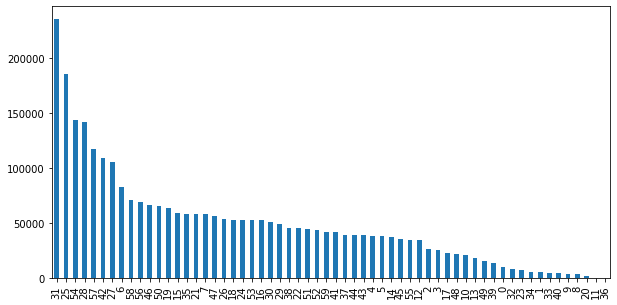

In [ ]:
records_per_shop = train.shop_id.value_counts().sort_values(ascending=False)
records_per_shop.plot(kind='bar',
                      figsize=(10,5),
                      #xlabel='Shop_ID',
                      #ylabel='Records'
                          )

### How do prices change over time?

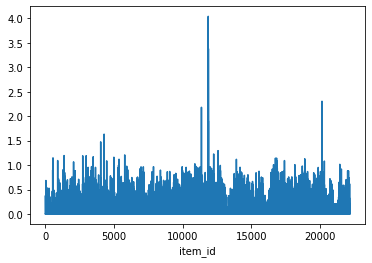

In [ ]:
price_var_mean = train.groupby('item_id')['item_price'].apply(lambda x:x.std()/x.mean()).fillna(0)
price_var_mean.plot()

In [ ]:
price_var_mean.describe()

count    19436.000000
mean         0.162681
std          0.182176
min          0.000000
25%          0.045288
50%          0.113448
75%          0.228483
max          4.043149
Name: item_price, dtype: float64

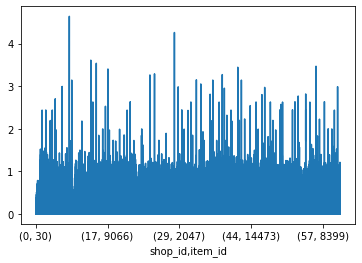

In [ ]:
price_var_in_shop = train.groupby(['shop_id','item_id'])['item_price'].apply(lambda x:x.std()/x.mean()).fillna(0)
price_var_in_shop.plot()

In [ ]:
price_var_in_shop.describe()

count    424124.000000
mean          0.079654
std           0.168456
min           0.000000
25%           0.000000
50%           0.000000
75%           0.084330
max           4.640910
Name: item_price, dtype: float64

Prices locally are more stable.

In [ ]:
price_var_in_shop.name = 'price_var'

In [ ]:
price_in_shop = price_var_in_shop.sort_values(ascending=False)
price_in_shop.head()

shop_id  item_id
7        11867      4.640910
28       11853      4.261235
14       11867      3.611674
15       11867      3.538782
56       11867      3.469097
Name: price_var, dtype: float64

It might be useful to see how price change affects sales for these items.

In [ ]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [ ]:
test.shape

(214200, 3)

In [ ]:
#item_categories = pd.read_csv('item_categories.csv')# not needed.
items = pd.read_csv('./data/items.csv.zip')
#shops = pd.read_csv('shops.csv') # not needed

`item_categories` provides 84 unique item categories with their 84 unique Ids.

Table `items` links `item_category_id` with `item_id` which is a feature in our train data set.  

In [ ]:
print('items shape is:', items.shape)
print('Numebr of unique values in `items`:\n', items.nunique())
items.head(3)

items shape is: (22170, 3)
Numebr of unique values in `items`:
 item_name           22170
item_id             22170
item_category_id       84
dtype: int64


item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40

Using `items`, we can merge `item_category_id` into out train data. We add a new column to our training data : `item_category_id`

In [ ]:
train_ext = train.join(items.set_index('item_id')[['item_category_id']], on='item_id')


Range of values of `item_id` is not [0, 22169], which is fine.

In [ ]:
train_ext.item_id.nunique(), max(train_ext.item_id)

(21807, 22169)

There is no missing data in training set.

In [ ]:
train_ext.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

We now have collected all the data in `train_ext`. Later, we should do the same thing for the test data:

In [ ]:
test_ext = test.join(items.set_index('item_id')[['item_category_id']],
          on='item_id')

test_ext.head()

ID  shop_id  item_id  item_category_id
0   0        5     5037                19
1   1        5     5320                55
2   2        5     5233                19
3   3        5     5232                23
4   4        5     5268                20

## EDA: item-store level

There are 424124 pairs of shop-item in data. It is surprising to nitoce that at store-item level, we have only one record for 25% of data, only 3 records for 50% of data and only 7 records for 75% of data!!

In [ ]:
item_store = train.groupby(['shop_id', 'item_id'])

In [ ]:
print(item_store.apply(len).describe())
print(item_store.apply(len).quantile([.5,.75, .80, .85, .9, .95, .97, .99]))


count    424124.000000
mean          6.922148
std          15.694255
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         867.000000
dtype: float64
0.50     3.0
0.75     7.0
0.80     8.0
0.85    11.0
0.90    15.0
0.95    25.0
0.97    35.0
0.99    64.0
dtype: float64


About 43% of data is from 2013.

In [ ]:
train_2013 = train.set_index('date')['2013']
train_2013.shape[0]/train.shape[0]

0.4317531317176054

About 35% of data is from 2014.

In [ ]:
train_2014 = train.set_index('date')['2014']
train_2014.shape[0]/train.shape[0]

0.3596441778851705

About 20% of data is from 2015.

In [ ]:
train_2015 = train.set_index('date')['2015']
train_2015.shape[0]/train.shape[0]

0.2086026903972241

There is 6692 pairs with more than 60 observations.

In [ ]:
(train_ > 50).sum()

6692

In [ ]:
6692/424124

0.015778404428893437

which is only about 1.5% of data. And, for about 93% of pairs, we have less than 20 observation.

In [ ]:
(train_ < 20).sum()

393468

In [ ]:
393468/424124

0.9277192519168922

In [ ]:
#grouped = train.groupby(['shop_id', 'item_id'])

In [ ]:
#dir(grouped)

In [ ]:
#grouped.groups

In [ ]:
train_item_cnt_daily = pd.pivot_table(train, values=['item_cnt_day'],
               index='date',
               columns=['shop_id', 'item_id'],
                        ).fillna(0)
train_item_cnt_daily = train_item_cnt_daily.fillna(0)

train_price_daily = pd.pivot_table(train, values=['item_price'],
               index='date',
               columns=['shop_id', 'item_id'],
                        ).ffill()
train_price_daily = train_price_daily['item_price'].bfill()

In [ ]:
train_price_daily

shop_id        0                        ...     59                     
item_id     30     31     32     33     ...  22155  22162  22164  22167
date                                    ...                            
2013-01-01  265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-02  265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-03  265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-04  265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-05  265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
...           ...    ...    ...    ...  ...    ...    ...    ...    ...
2015-10-27  265.0  434.0  221.0  347.0  ...  149.0  349.0  699.0  299.0
2015-10-28  265.0  434.0  221.0  347.0  ...  149.0  349.0  699.0  299.0
2015-10-29  265.0  434.0  221.0  347.0  ...  149.0  349.0  699.0  299.0
2015-10-30  265.0  434.0  221.0  347.0  ...  149.0  349.0  699.0  299.0
2015-10-31  265.0  434.0  221.0  347.0  ...  149.0  349.0  699.0  299.0

[1034 rows x 424124 columns]

In [ ]:
#train_daily.to_csv('train_daily.csv')

In [ ]:
#train_daily = pd.read_csv('train_daily.csv')

In [ ]:
train_daily.head()

shop_id       0                           ...    59                        
item_id    30    31    32    33    35     ... 22154 22155 22162 22164 22167
date                                      ...                              
2013-01-01   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-01-02   0.0   0.0   0.0   0.0   0.0  ...   1.0   0.0   0.0   0.0   0.0
2013-01-03   0.0   0.0   2.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-01-04   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-01-05   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0

[5 rows x 424124 columns]

In [ ]:
train_2 = train_daily.resample('2d').sum()

In [ ]:
train_3 = train_daily.resample('3d').sum()

In [ ]:
train_4 = train_daily.resample('4d').sum()

In [ ]:
train_6 = train_daily.resample('6d').sum()

In [ ]:
train_weekly = train_daily.resample('w').sum()

In [ ]:
train_weekly

shop_id       0                           ...    59                        
item_id    30    31    32    33    35     ... 22154 22155 22162 22164 22167
date                                      ...                              
2013-01-06   0.0   0.0   2.0   1.0   0.0  ...   1.0   0.0   0.0   0.0   0.0
2013-01-13   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-01-20   0.0   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-01-27   0.0   0.0   3.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-02-03   0.0   0.0   1.0   1.0   4.0  ...   0.0   0.0   0.0   0.0   0.0
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
2015-10-04   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2015-10-11   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2015-10-18   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2015-10-25   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2015-11-01   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0

[148 rows x 424124 columns]

In [ ]:
train_monthly = train_item_cnt_daily.resample('m').sum()

We have returns within a month for some itmes:

In [ ]:
(train_monthly==-1).any().any()

True

Let's select some random items at some random shops:

In [ ]:
plot_cols = list(np.random.choice(train_daily.columns, 30))
plot_cols

[(48, 17388),
 (28, 5572),
 (6, 6002),
 (44, 21470),
 (23, 8432),
 (2, 1077),
 (50, 11127),
 (47, 15464),
 (35, 3770),
 (55, 6997),
 (10, 5012),
 (37, 19790),
 (54, 6536),
 (2, 15301),
 (30, 3591),
 (9, 21078),
 (18, 6673),
 (54, 11115),
 (21, 4251),
 (47, 9042),
 (30, 1874),
 (13, 21883),
 (35, 20181),
 (54, 9281),
 (45, 19430),
 (31, 2765),
 (56, 18407),
 (44, 6926),
 (30, 19066),
 (19, 1914)]

and look at their `weekly` sale:

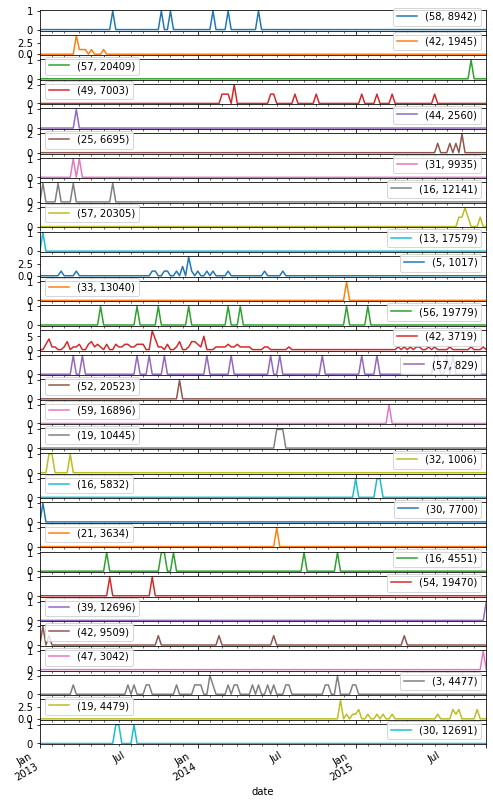

In [ ]:
plot_features = train_weekly[plot_cols]
#plot_features.index = date_time
_ = plot_features.plot(subplots=True,
                      figsize=(8,15))

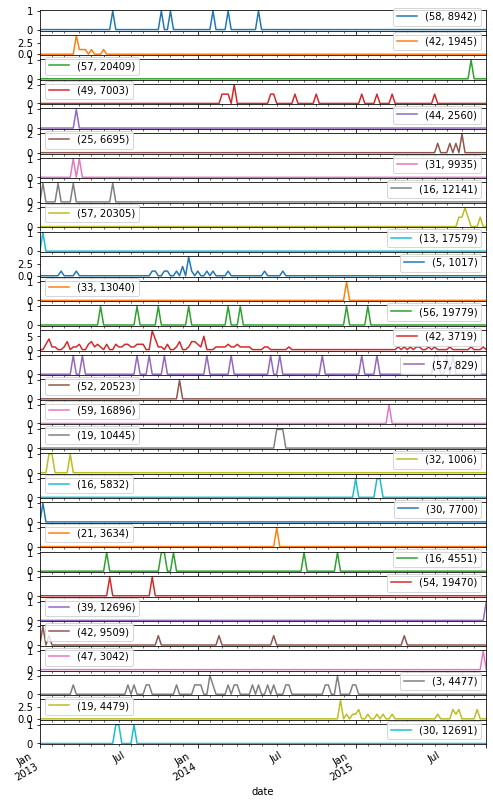

In [ ]:
plot_features = train_weekly[plot_cols]
#plot_features.index = date_time
_ = plot_features.plot(subplots=True,
                      figsize=(8,15))

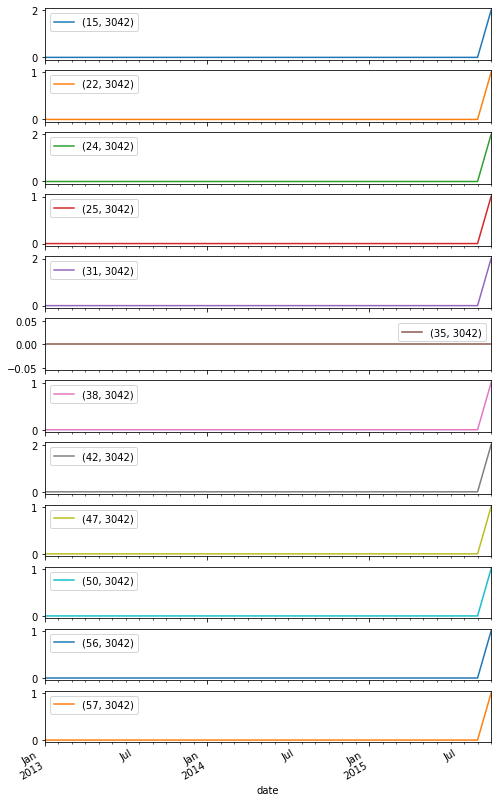

In [ ]:
plot_features = train_monthly[plot_cols]
_ = plot_features.plot(subplots=True,
                      figsize=(8,15))



```
# This is formatted as code
```

It maight be useful to create biweekly data as well. Check it later!
Now let's look at the sale of some of the above items across different shops.

In [ ]:
items_ids = np.random.choice([i[1] for i in plot_cols],8)

In [ ]:
items_ids

array([21470, 15464,  6002,  2765,  9042, 11115, 11115, 21470])

#### Monthly Sales

25 shops sold item# 2727
27 shops sold item# 18039
26 shops sold item# 21439
47 shops sold item# 3935
38 shops sold item# 7050
47 shops sold item# 7809
34 shops sold item# 18880
38 shops sold item# 14595


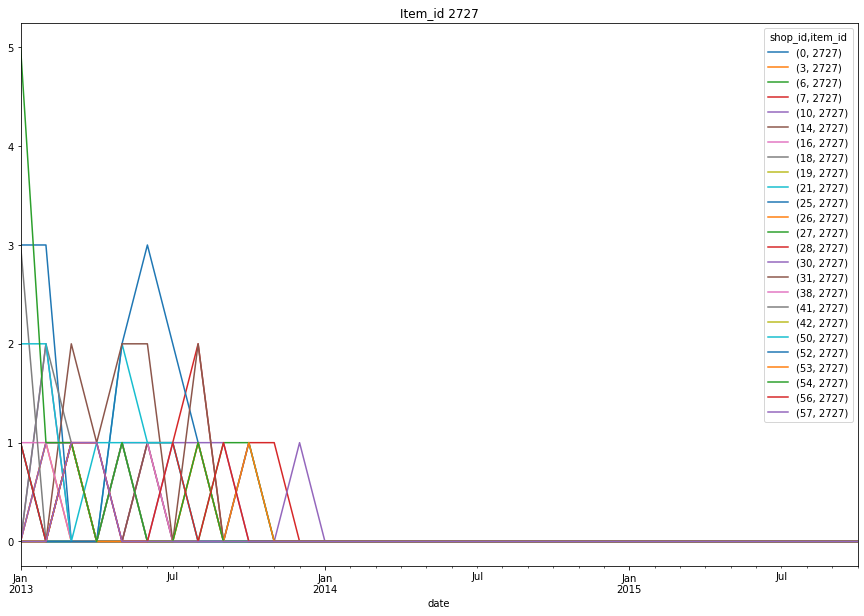

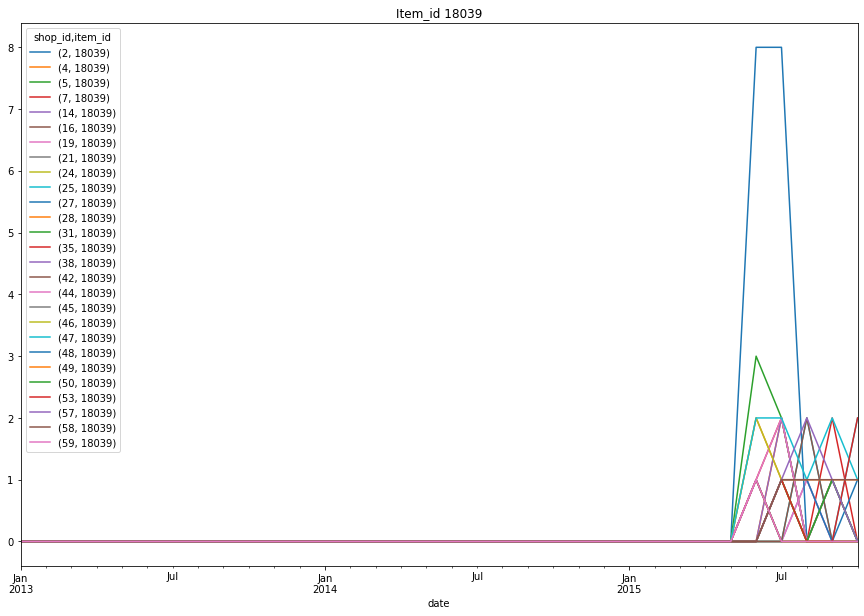

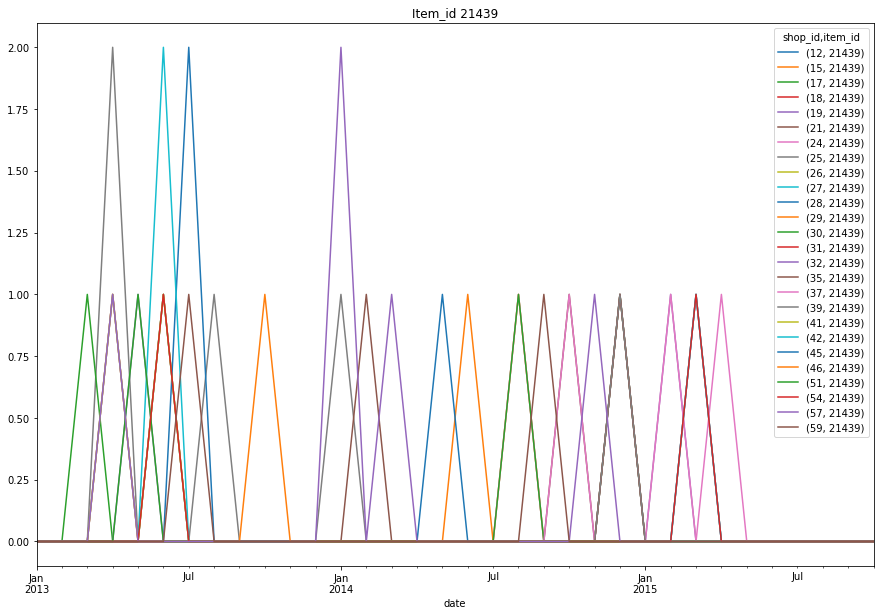

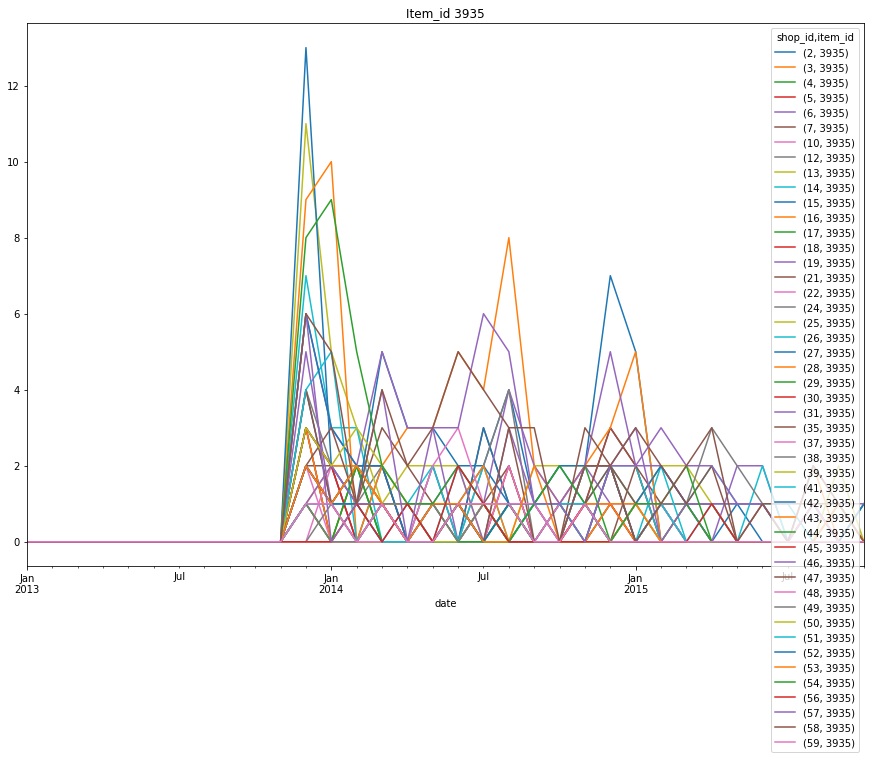

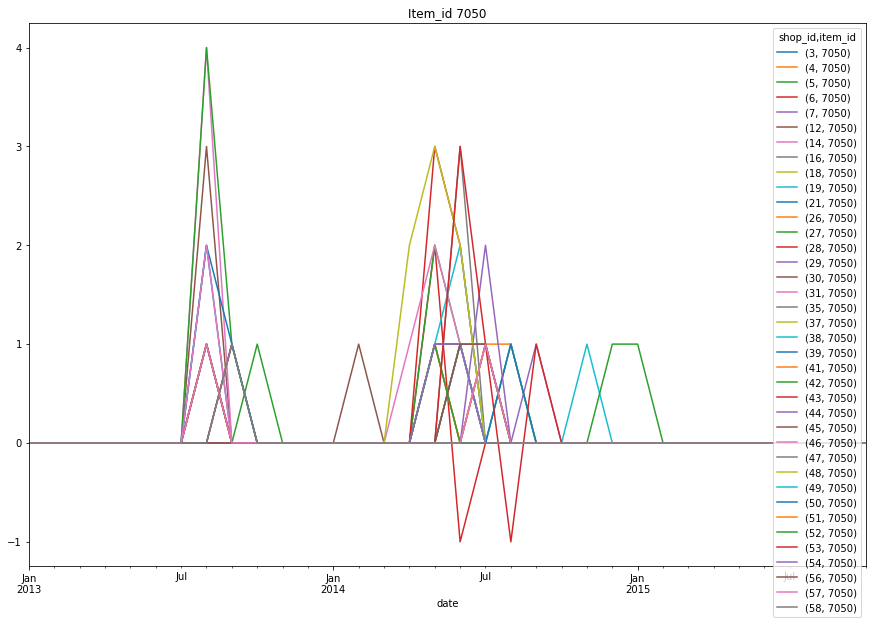

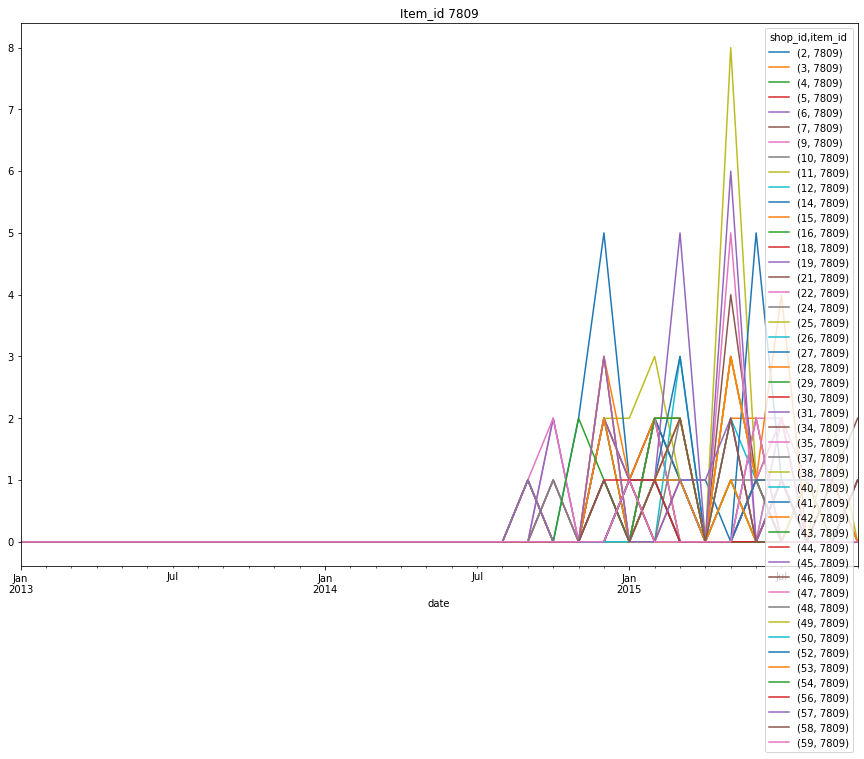

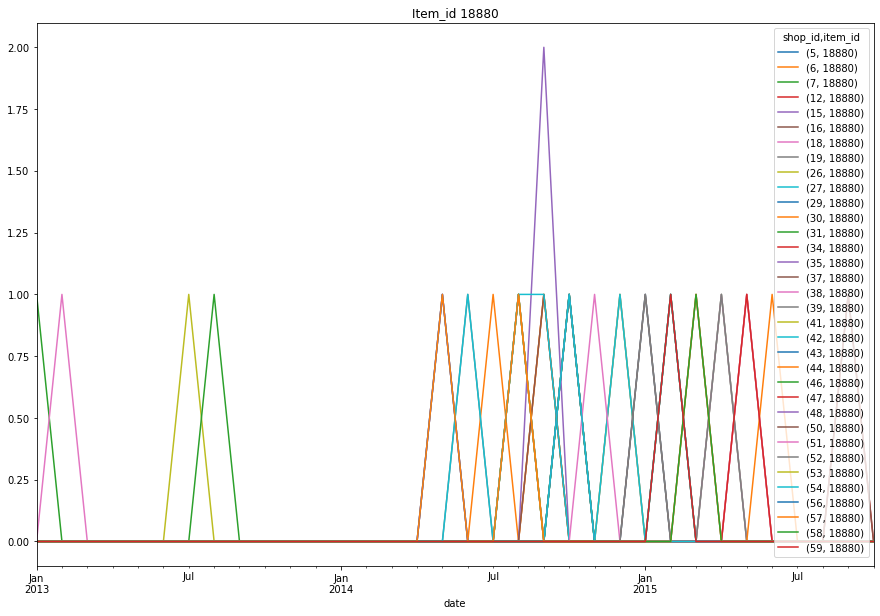

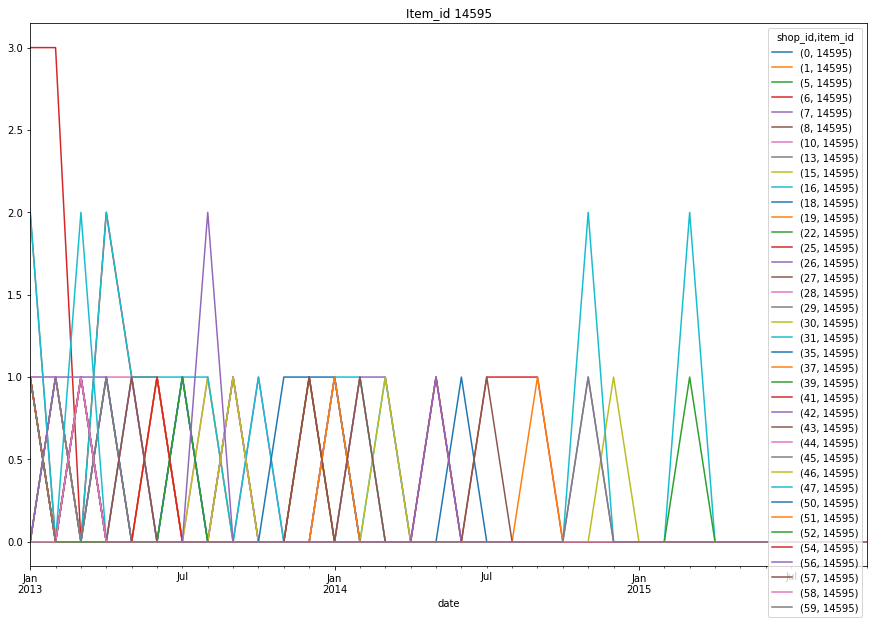

In [ ]:
for items in items_ids:
    plot_cols = [(shops, items) for shops in range(60) if (shops, items) in train_daily.columns]
    plot_features = train_monthly[plot_cols]
    _ = plot_features.plot(figsize=(15,10), title='Item_id %d'%items)
    print('%d shops sold item# %d'%(len(plot_cols), items))



It can be easily seen that items stop/start selling across all shops which could mean they get into the market and get out some time later.

22 shops sold item# 21470
24 shops sold item# 15464
50 shops sold item# 6002
23 shops sold item# 2765
47 shops sold item# 9042
2 shops sold item# 11115
2 shops sold item# 11115
22 shops sold item# 21470


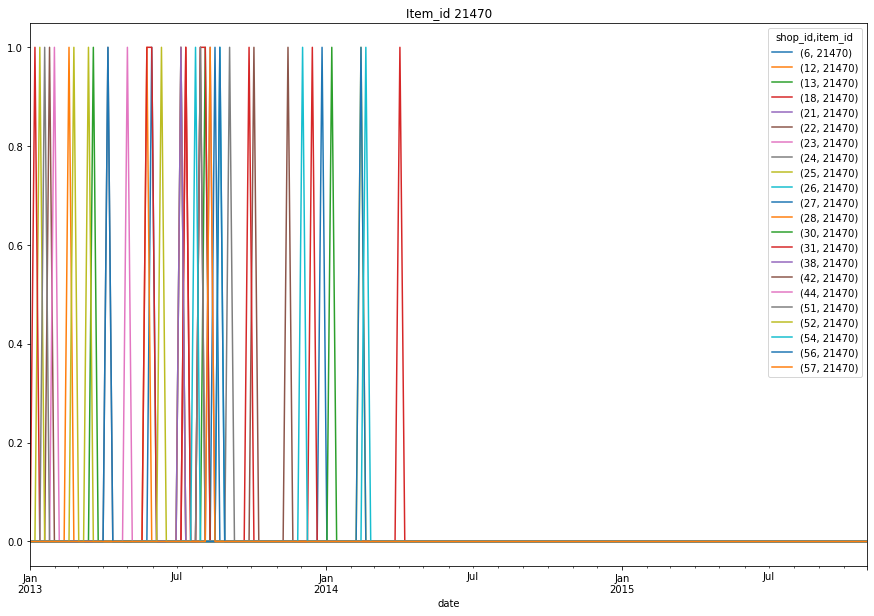

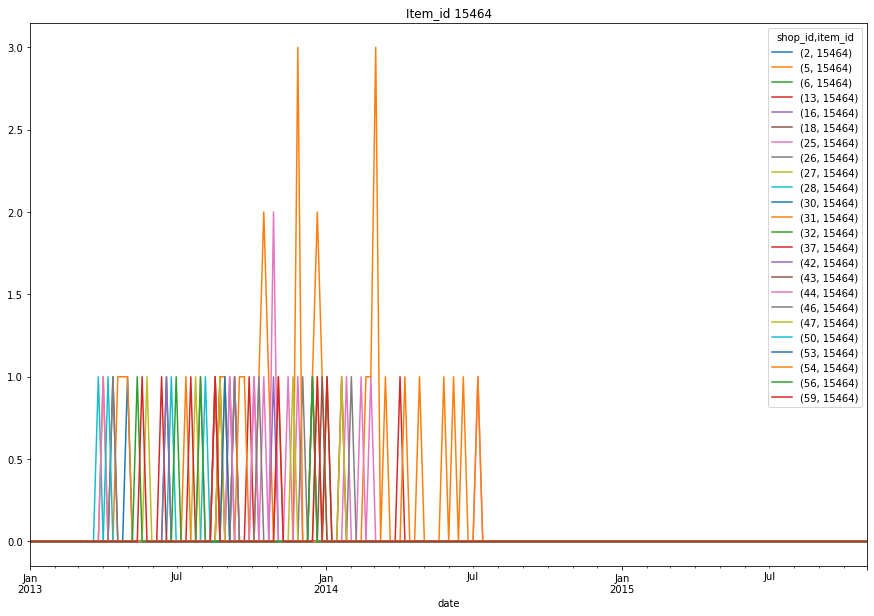

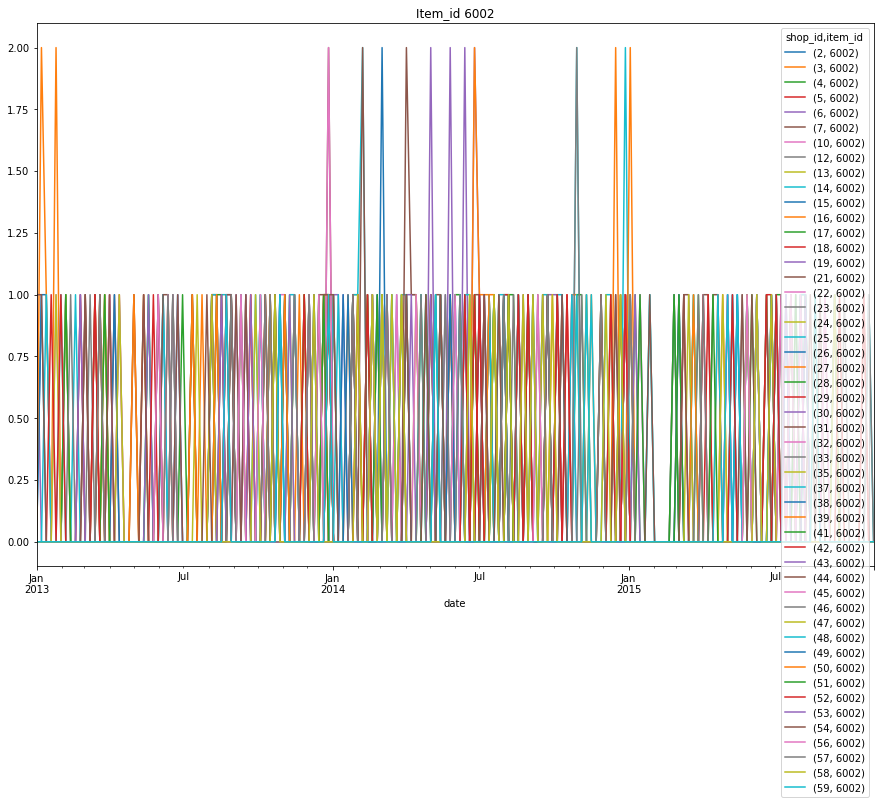

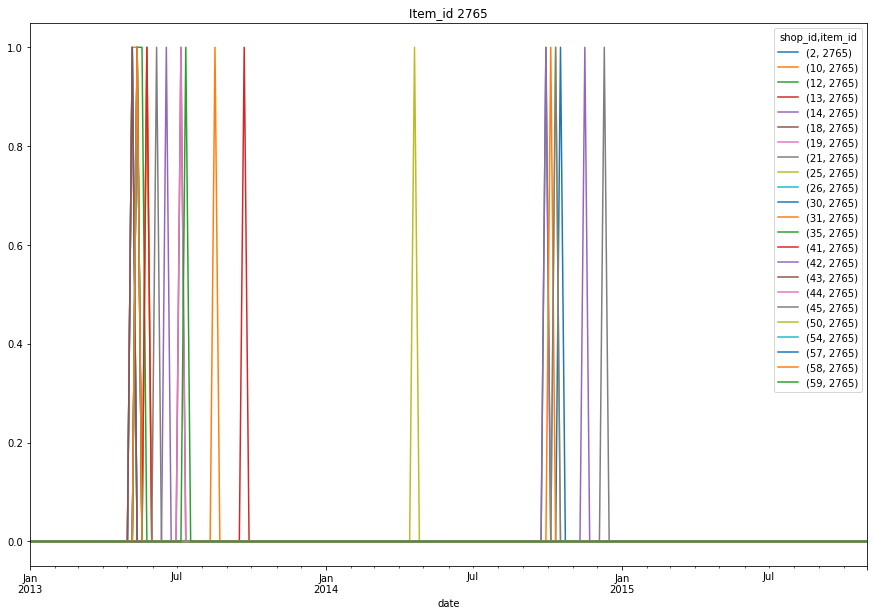

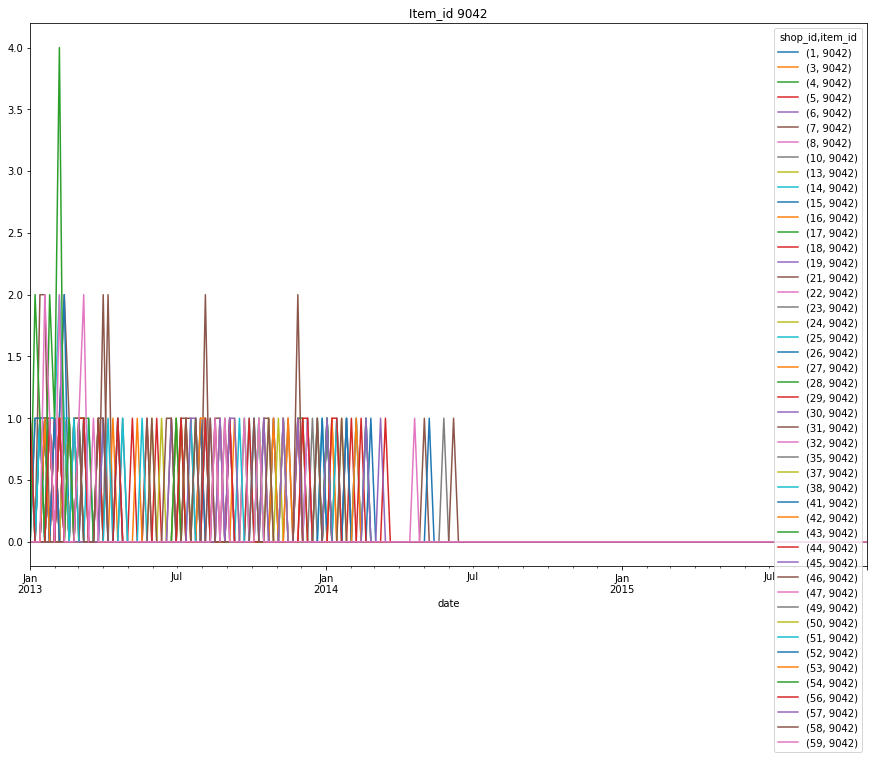

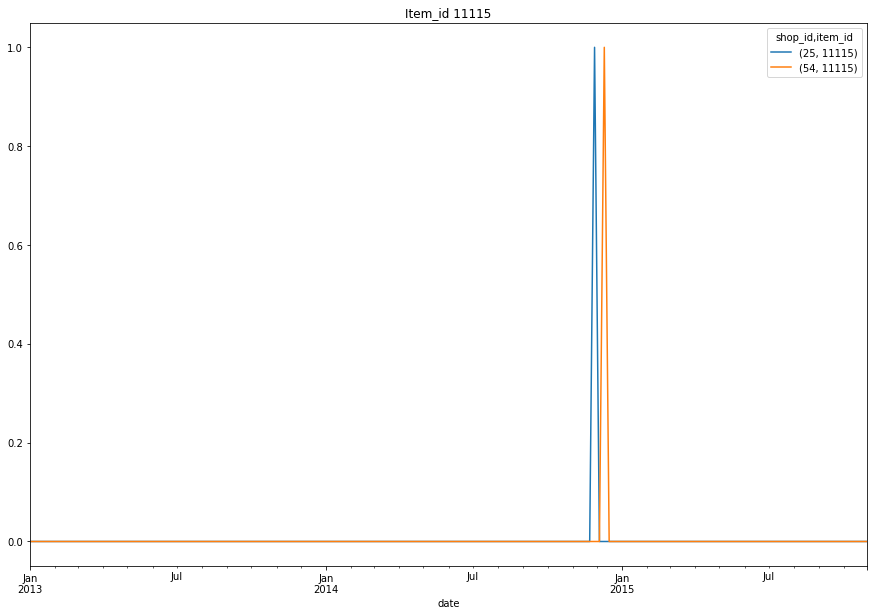

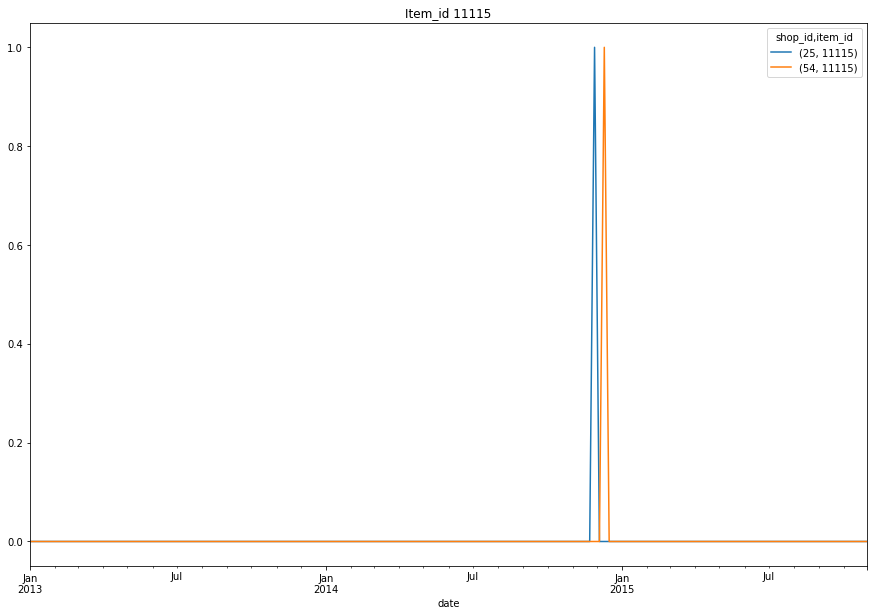

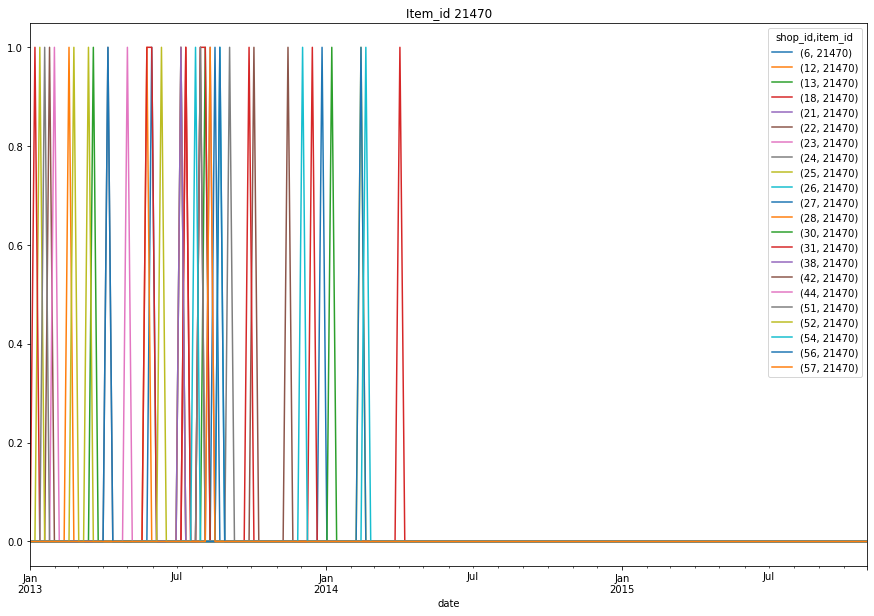

In [ ]:
for items in items_ids:
    plot_cols = [(shops, items) for shops in range(60) if (shops, items) in train_6.columns]
    plot_features = train_6[plot_cols]
    _ = plot_features.plot(figsize=(15,10), title='Item_id %d'%items)
    print('%d shops sold item# %d'%(len(plot_cols), items))


#### Weekly Sales

33 shops sold item# 16896
43 shops sold item# 10445
30 shops sold item# 12696
12 shops sold item# 17579
22 shops sold item# 1945
13 shops sold item# 2560
49 shops sold item# 4551
12 shops sold item# 3042


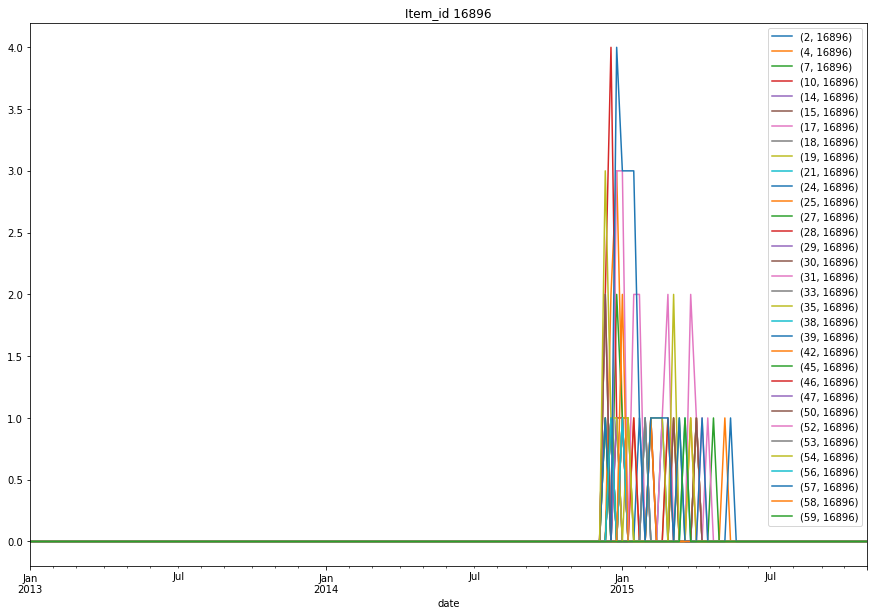

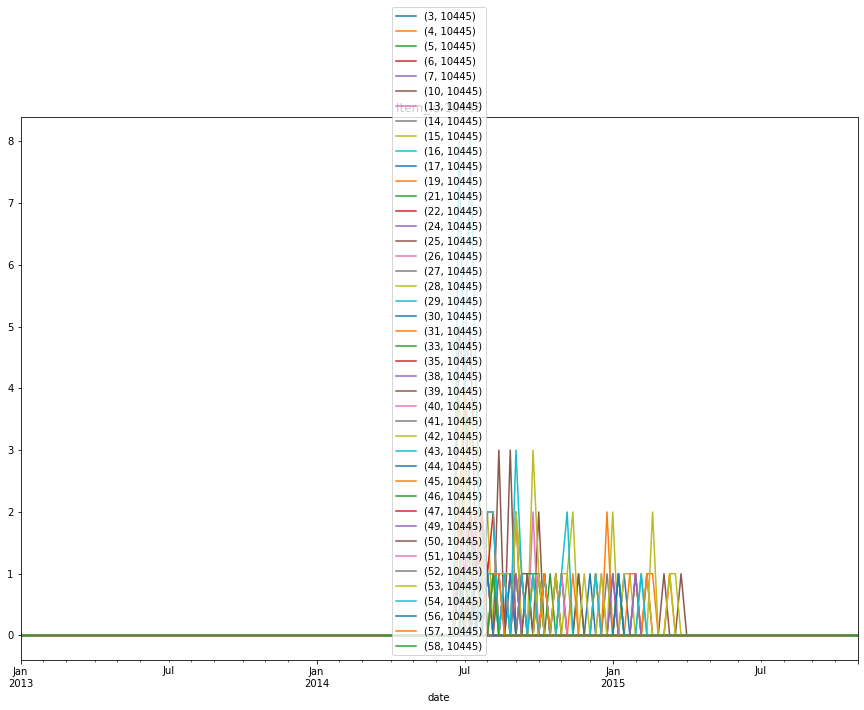

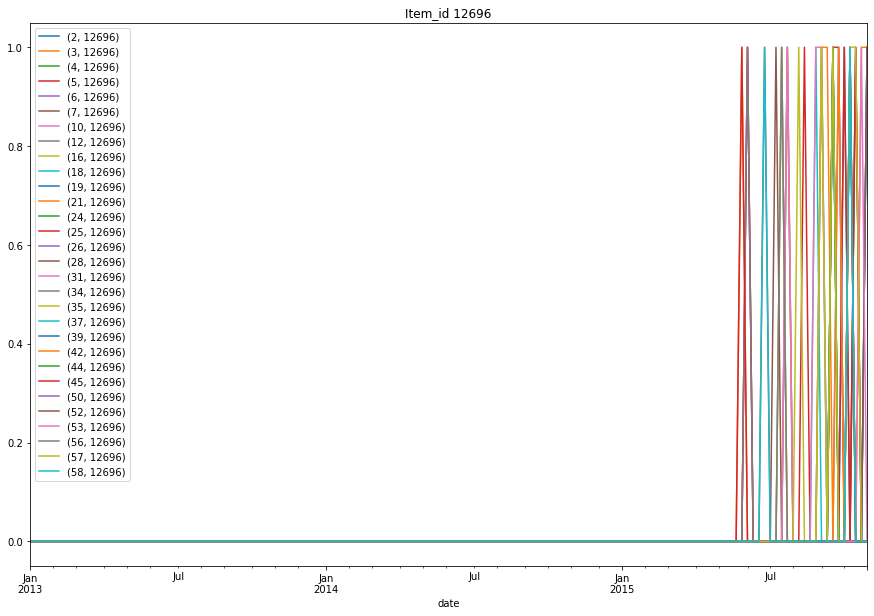

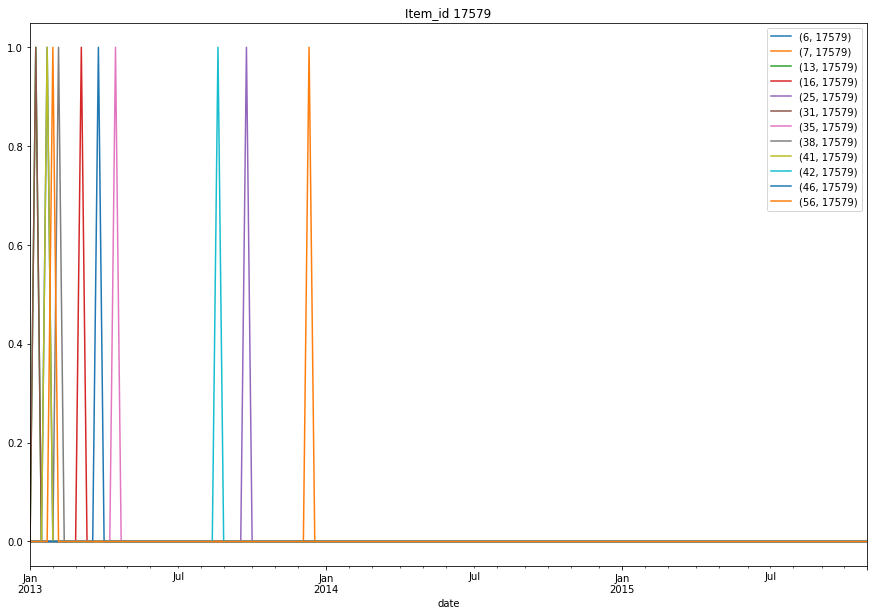

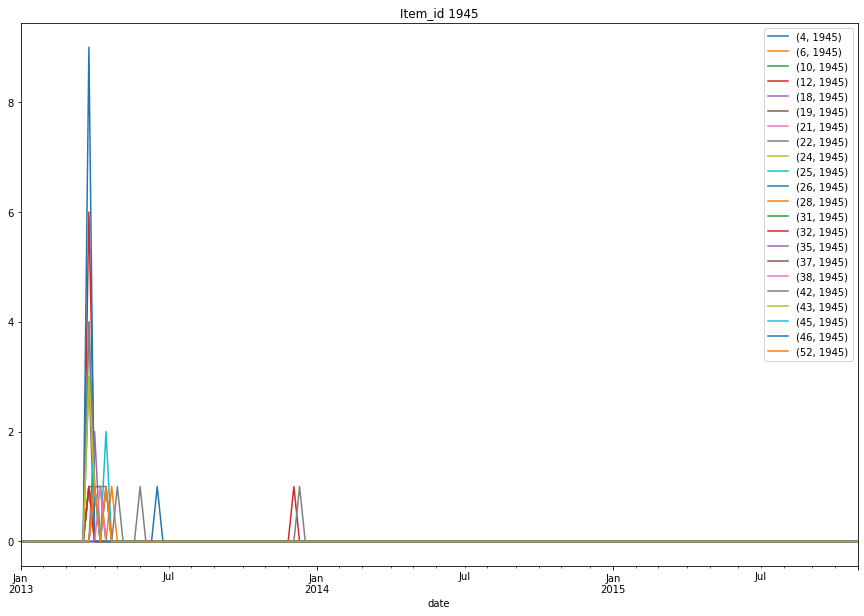

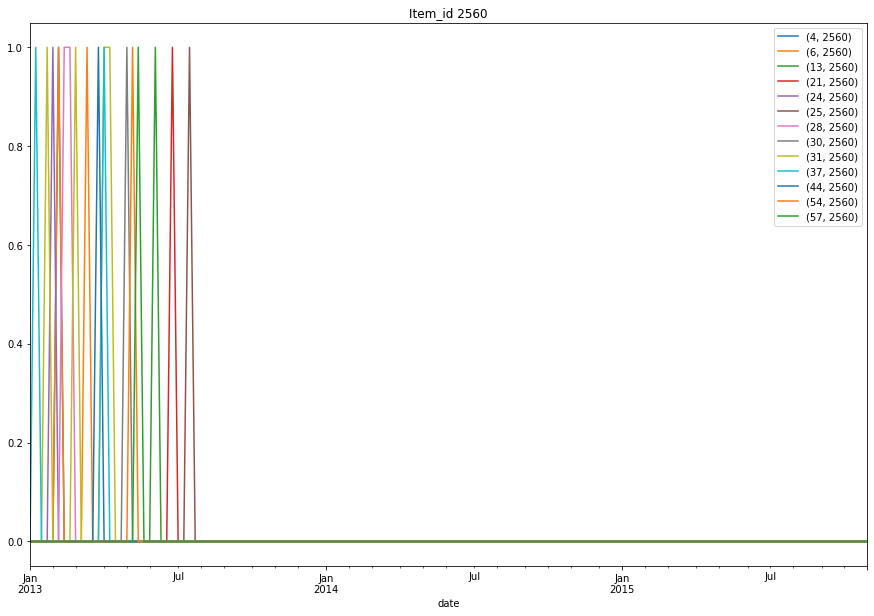

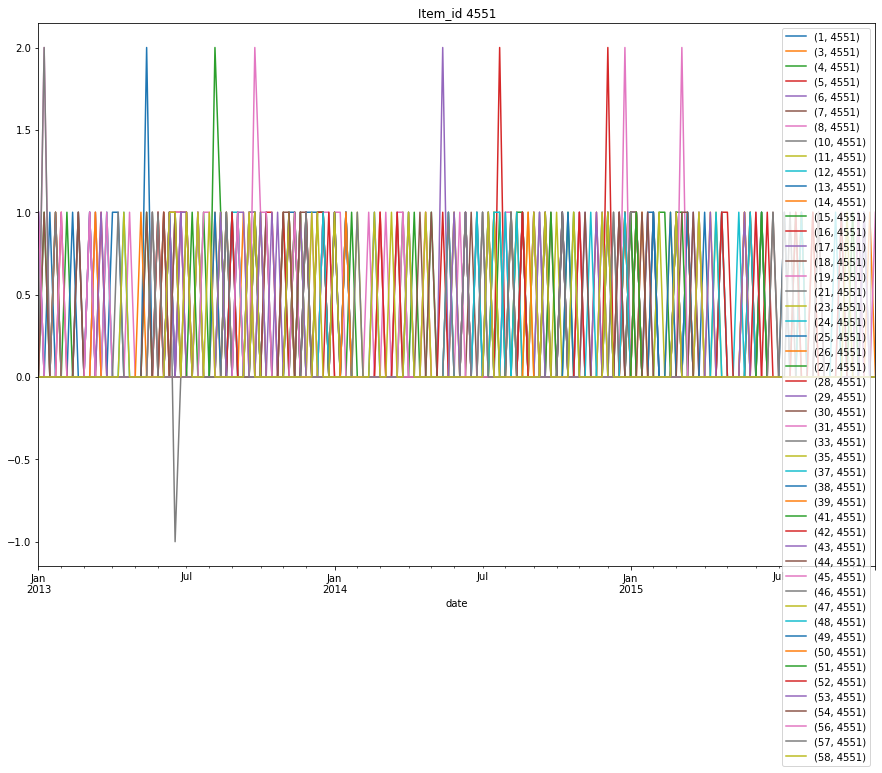

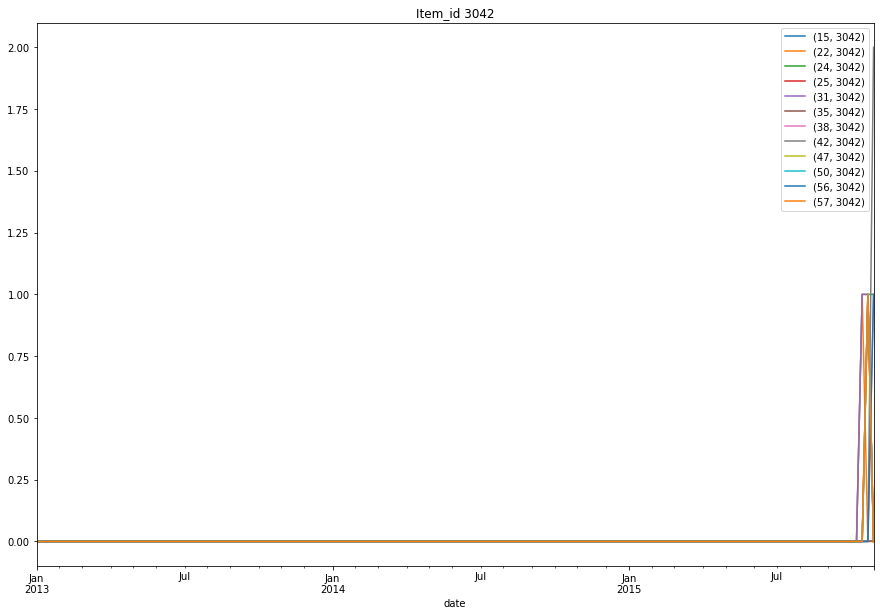

In [ ]:
for items in items_ids:
    plot_cols = [(shops, items) for shops in range(60) if (shops, items) in train_daily.columns]
    plot_features = train_weekly[plot_cols]
    _ = plot_features.plot(figsize=(15,10), title='Item_id %d'%items)
    print('%d shops sold item# %d'%(len(plot_cols), items))




It is interesting to note that the _weekly sales_ across shops for different items follows a very regular pattern compared to _monthly sales_ . This suggests that we might want to work with weekly data.

#### Effect of price change on sales

In [ ]:
plot_cols = price_in_shop[price_in_shop > 5000].index

In [ ]:
train_weekly_price = train_daily_price.resample('7d').mean()

NameError: ignored

/Users/Yas/DS/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


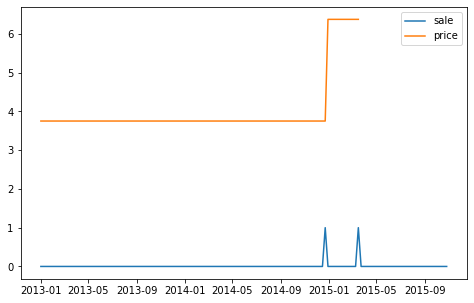

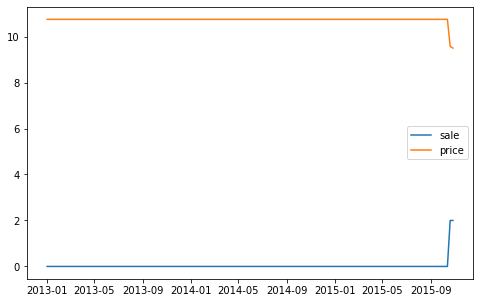

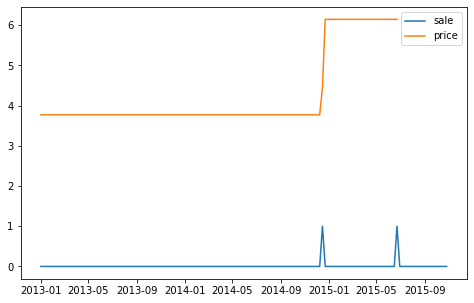

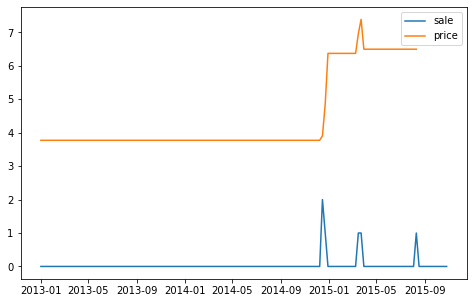

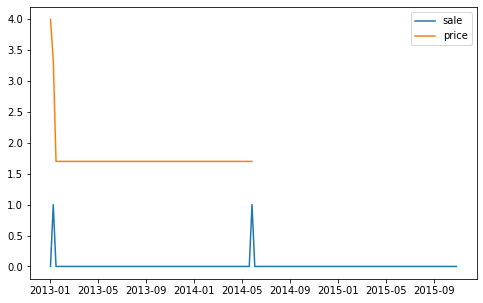

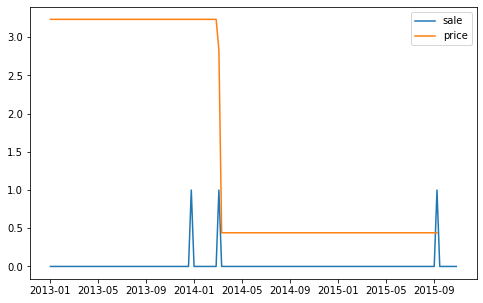

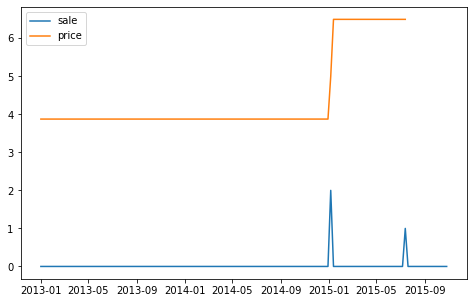

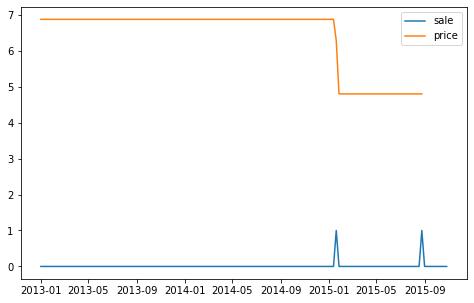

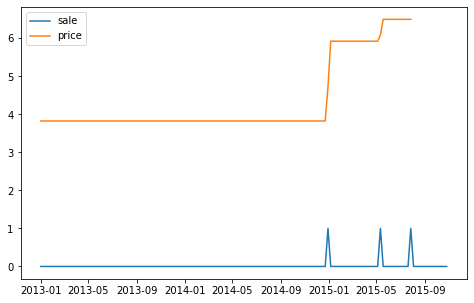

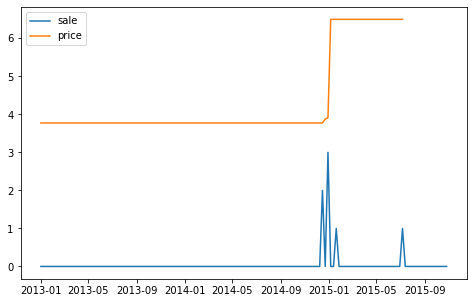

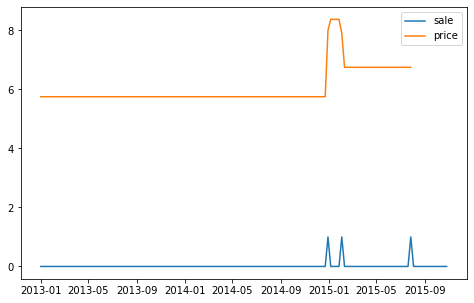

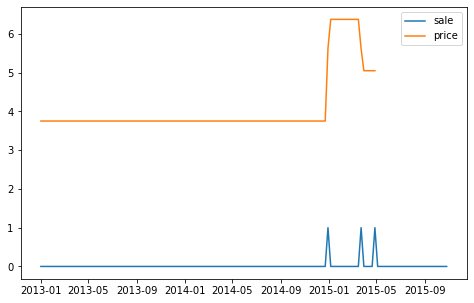

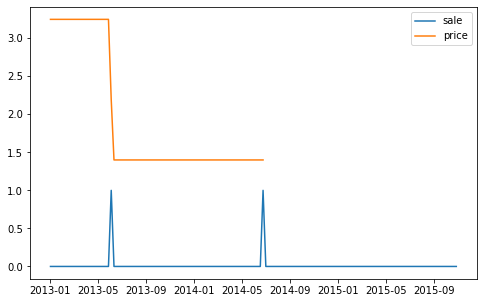

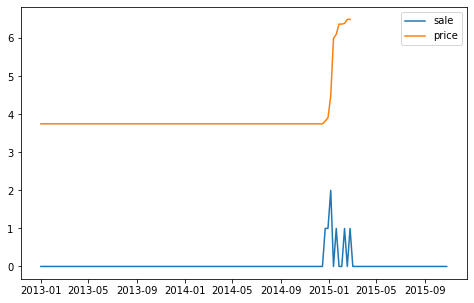

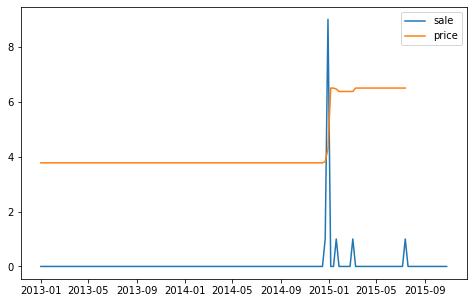

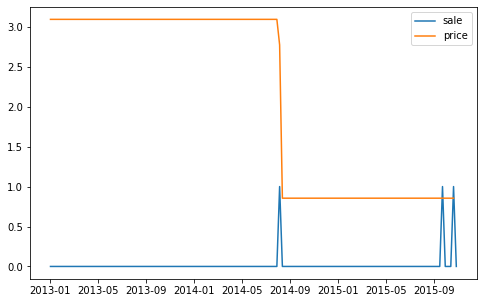

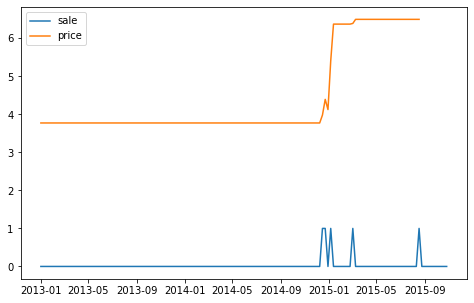

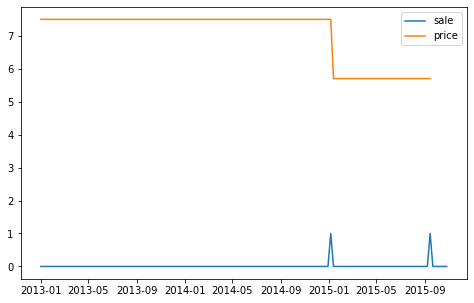

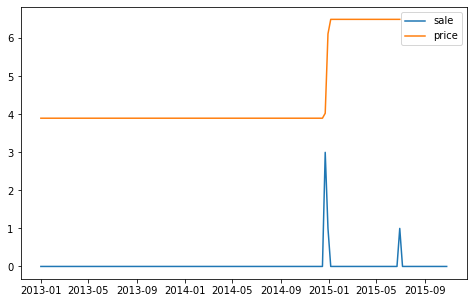

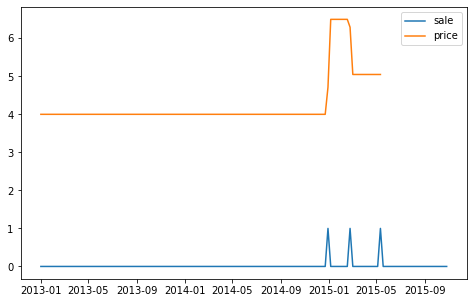

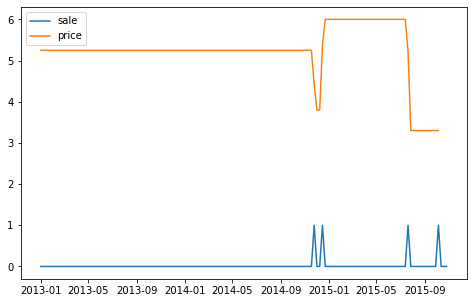

In [ ]:
for j in plot_cols:
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()
    ax.plot(train_weekly[j],label='sale')
    ax.plot(train_weekly_price[j]/4000, label='price')
    ax.legend()

#_ = train_weekly[plot_cols].plot(subplots=True, figsize=(8,25))


It does not look like there is a meaningful correlation between sales and prices.

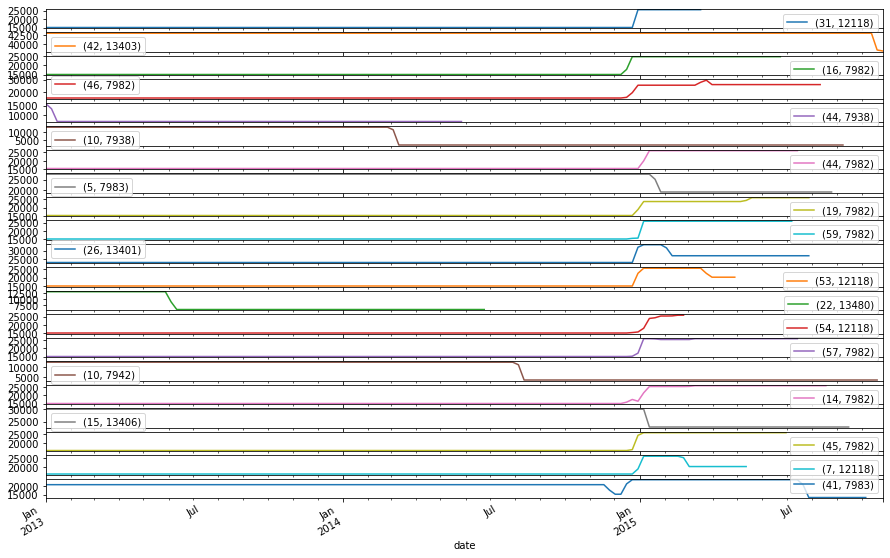

In [ ]:
_ = train_weekly_price[plot_cols].plot(subplots=True, figsize=(15,10))

#### Data Windowing

I split the data into train and validation parts. I do not assign any portion for testing because the data is very sparse.

In [ ]:
n = len(train_monthly)
train_df = train_monthly[0:int(n*0.85)]
val_df = train_monthly[int(n*0.85):]

In [ ]:
train_df.shape, val_df.shape

((28, 424124), (6, 424124))

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
            train_df=train_df,
            val_df=val_df,
            label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df

        # Work out the window parameters.

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_indices = np.arange(self.total_window_size)[:self.input_width]

        self.label_start = self.total_window_size - self.label_width
        self.label_indices = np.arange(self.total_window_size)[self.label_start:]

    def __repr__(self):
            return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
            ])

In [ ]:
w1 = WindowGenerator(input_width=12, label_width=4, shift=4)

In [ ]:
w1

Total window size: 16
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15]

In [ ]:
def split_window(self, features):
    inputs = features[:, :self.input_width, :]
    labels = features[:, self.label_start:, :]

    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = np.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[20:20+w1.total_window_size]),
                           np.array(train_df[50:50+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 16, 424124)
Inputs shape: (3, 12, 424124)
Labels shape: (3, 4, 424124)


### Create tf.data.Datasets

In [ ]:
import tensorflow as tf

Normalize the data before feeding it into deep nets. The mean and standard deviation should only be computed using the training data. To avoid division by zero, we do not scale features with zero varianve (divide them by 1).

In [ ]:
train_std = train_df.std()
train_std.loc[:, train_std == 0] = 1

To compute normalization faster, we convert DataFrame to NumPy array.

In [ ]:
train_mean = train_df.mean()
train_mean = np.array(train_mean, dtype=np.float32)
train_std = np.array(train_std, dtype=np.float32)

Finally this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of (input_window, label_window) pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    data = (data - train_mean)/ train_std # Normalize data now
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset



In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def example(self):

    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train)) # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The Dataset.element_spec property tells you the structure, dtypes and shapes of the dataset elements.

In [ ]:
w1.train.element_spec

(TensorSpec(shape=(None, None, 424124), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, None, 424124), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches:

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 424124)
Labels shape (batch, time, features): (32, 4, 424124)


##### Plot

In [ ]:
def plot(self,  model=None, plot_col=(19, 4479), max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue



        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

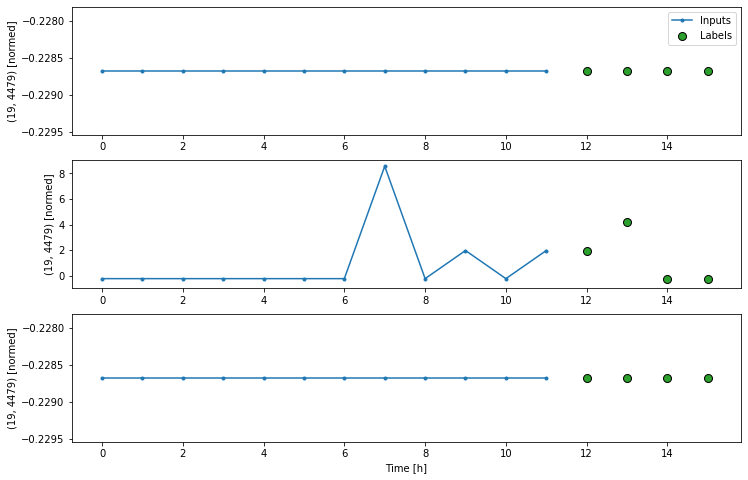

In [ ]:
w1.plot()

### Deep Net Models

As we will try different models, we package the training procedure into a function:

In [ ]:
def compile_and_fit(model, window, MAX_EPOCHS = 20, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping]
                       )
    return history

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15 16 17 18]

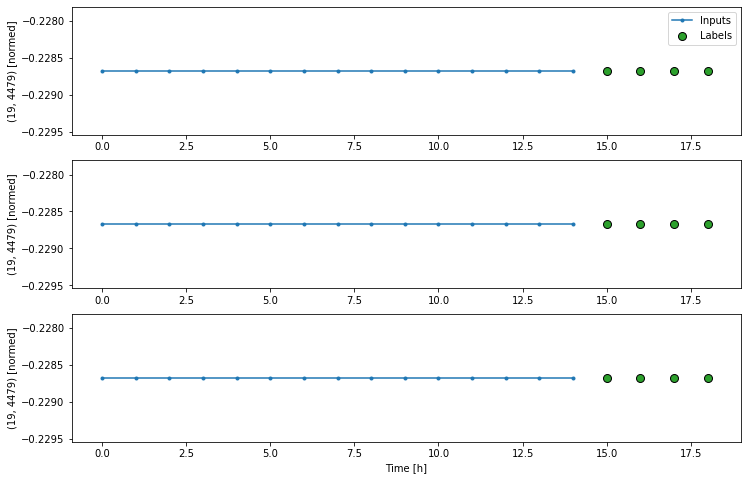

In [ ]:
OUT_STEPS = 4
multi_window = WindowGenerator(input_width=15,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
num_features = train_df.shape[1]

### Dense

In [ ]:
multi_val_performance = {}

Epoch 1/20
4/4 [==============================] - 32s 8s/step - loss: 0.8183 - mean_absolute_error: 0.2829 - val_loss: 3.3475 - val_mean_absolute_error: 0.1954
Epoch 2/20
4/4 [==============================] - 19s 5s/step - loss: 0.8303 - mean_absolute_error: 0.2929 - val_loss: 3.3557 - val_mean_absolute_error: 0.2202
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 1.0190 - mean_absolute_error: 0.4487 - val_loss: 3.3506 - val_mean_absolute_error: 0.2129
Epoch 4/20
4/4 [==============================] - 15s 4s/step - loss: 1.1865 - mean_absolute_error: 0.6002 - val_loss: 3.4379 - val_mean_absolute_error: 0.3430
Epoch 5/20
4/4 [==============================] - 17s 4s/step - loss: 1.9440 - mean_absolute_error: 0.8706 - val_loss: 3.3588 - val_mean_absolute_error: 0.2251
Epoch 6/20
4/4 [==============================] - 17s 4s/step - loss: 1.3590 - mean_absolute_error: 0.7523 - val_loss: 3.3585 - val_mean_absolute_error: 0.2305
Epoch 7/20
4/4 [========================

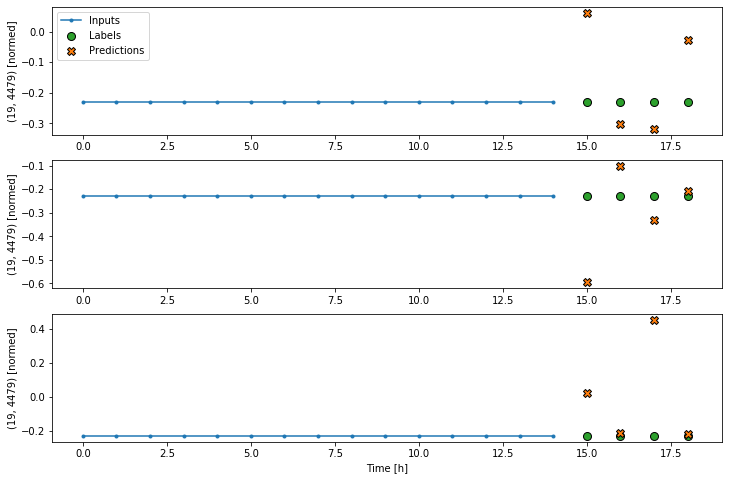

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(256, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros
                         ),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_window.plot(multi_dense_model)

In [ ]:
multi_dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, None, 424124)      0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 256)         108576000 
_________________________________________________________________
dense_2 (Dense)              (None, None, 1696496)     435999472 
_________________________________________________________________
reshape (Reshape)            (None, 4, 424124)         0         
Total params: 544,575,472
Trainable params: 544,575,472
Non-trainable params: 0
_________________________________________________________________


#### Model 2: CNN

In [ ]:
CONV_WIDTH = 4

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(filters=256,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

In [ ]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', conv_model(multi_window.example[0]).shape)

Input shape: (32, 15, 424124)
Output shape: (32, 4, 424124)


In [ ]:
conv_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (32, 4, 424124)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (32, 1, 256)              434303232 
_________________________________________________________________
dense_10 (Dense)             (32, 1, 1696496)          435999472 
_________________________________________________________________
reshape_5 (Reshape)          (32, 4, 424124)           0         
Total params: 870,302,704
Trainable params: 870,302,704
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(conv_model, multi_window, MAX_EPOCHS = 20)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(multi_window.val)


1/1 [==============================] - 0s 24ms/step - loss: 3.3568 - mean_absolute_error: 0.2285


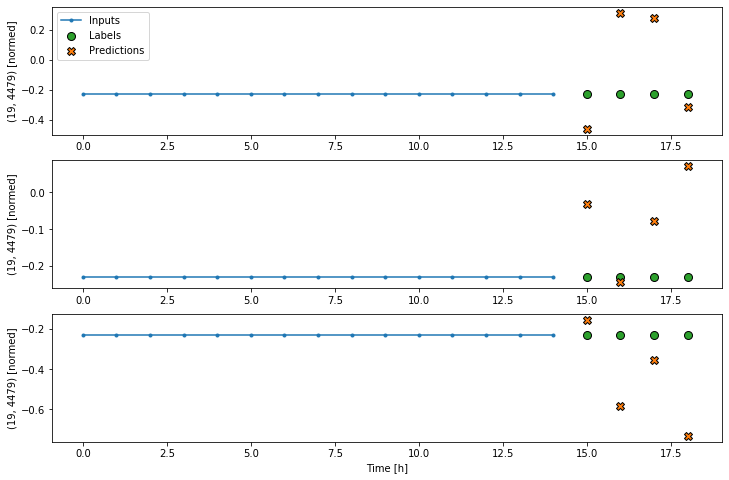

In [ ]:
multi_window.plot(conv_model)

#### Advanced: Autoregressive mode

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step LSTM models: An LSTM followed by a layers.Dense that converts the LSTM outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See Keras RNNs for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 424124])

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                              training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 4, 424124)


In [ ]:
multi_val_performance = {}

1/1 [==============================] - 0s 2ms/step - loss: 3.3531 - mean_absolute_error: 0.2051


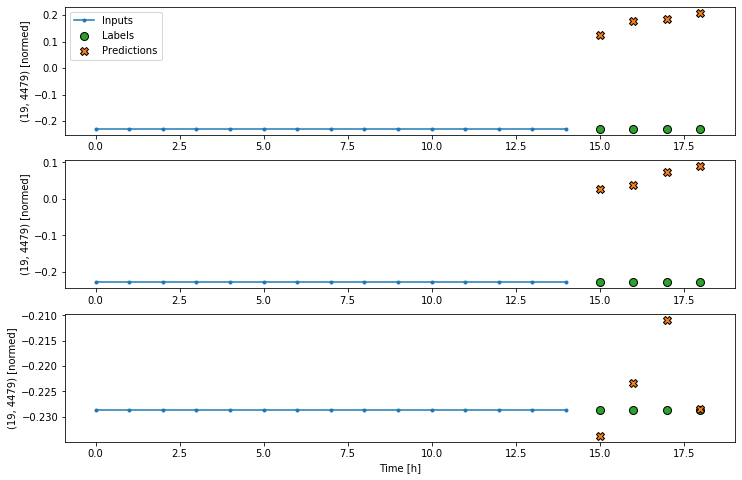

In [ ]:
history = compile_and_fit(feedback_model, multi_window, MAX_EPOCHS = 20, patience=7)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_window.plot(feedback_model)

In [ ]:
multi_val_performance['AR LSTM']

NameError: ignored

## A New Approach

In [ ]:
train_item_cnt_daily = pd.pivot_table(train,
                                      values=['item_cnt_day'],
                                      index='date',
                                      columns=['shop_id', 'item_id', 'item_category_id'],).fillna(0)
train_monthly = train_item_cnt_daily['item_cnt_day'].resample('m').sum().astype(np.float16)

In [ ]:
train_monthly.head()

shop_id             0                           ...    59                        
item_id          30    31    32    33    35     ... 22154 22155 22162 22164 22167
item_category_id    40    37    40    37    40  ...    37    37    40    37    49
date                                            ...                              
2013-01-31         0.0   0.0   6.0   3.0   1.0  ...   1.0   0.0   0.0   0.0   0.0
2013-02-28        31.0  11.0  10.0   3.0  14.0  ...   0.0   0.0   0.0   0.0   0.0
2013-03-31         0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-04-30         0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2013-05-31         0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0

[5 rows x 424124 columns]

In [ ]:
train_price_daily = pd.pivot_table(train, values=['item_price'],
                                   index='date',
                                   columns=['shop_id', 'item_id', 'item_category_id']).ffill()
train_price_daily = train_price_daily['item_price'].bfill().astype(np.float32)

In [ ]:
train_price_daily.head()

shop_id              0                        ...     59                     
item_id           30     31     32     33     ...  22155  22162  22164  22167
item_category_id     40     37     40     37  ...     37     40     37     49
date                                          ...                            
2013-01-01        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-02        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-03        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-04        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-05        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0

[5 rows x 424124 columns]

In [ ]:
#items = pd.read_csv('./data/items.csv.zip')[['item_id', 'item_category_id']]

### Part I of input date

In [ ]:
#train_monthly

In [ ]:
dataI = train_monthly
dataI.shape

(34, 424124)

In [ ]:
# def create_dataset(self, data):
#     lags = ['lag_{}'.format(i+1) for i in range(self.lag_length)]
#     columns = ['store_id', 'item_id']
#     columns.extend(lags)
#     columns.extend(['month_of_pred', 'year_of_pred'])
#     columns.extend(['label'])
#     prep_data = pd.DataFrame()
#     length = data.shape[0]
#     if length == 0: return None
#     n = length-self.window_size+1
#     for i in range(0,n):
#       df1 = pd.DataFrame(data[i:i+self.lag_length].T.reset_index().values,
#                           dtype='int32')
#       df3 = pd.DataFrame({#'week': round(np.mean(self.train_df[i:i+self.lag_length].index.map(lambda x:x.week)),2),
#                             'month_of_pred': [np.mean(data[i+self.window_size-1: i+self.window_size].index.map(lambda x:x.month))]*df1.shape[0],
#                             'year_of_pred': [np.mean(data[i+self.window_size-1: i+self.window_size].index.map(lambda x:x.year))]*df1.shape[0]
#                             }, dtype='int32')
#       df2 = pd.DataFrame({'label':data[i+self.window_size-1: i+self.window_size].T.values.reshape(-1)},
#                             dtype='int32')
#       prep_data = prep_data.append(pd.concat([df1, df3, df2], axis=1, ignore_index=True))

#     prep_data.columns = columns
#     return prep_data

# def create_dataset(self, data, prefix='lag_item_cnt_{}', with_price=False):
#     columns = []
#     lags = [prefix.format(i+1) for i in range(self.lag_length)]
#     prep_data = pd.DataFrame()
#     length = data.shape[0]
#     n = length - self.window_size + 1
#     if not with_price:
#         columns.extend(['store_id', 'item_id'])
#         columns.extend(lags)
#         columns.extend(['month_of_pred', 'year_of_pred'])
#         columns.extend(['label'])
#         for i in range(0,n):
#             df1 = pd.DataFrame(data[i:i+self.lag_length].T.reset_index().values,
#                                 dtype='float32')

#             df3 = pd.DataFrame({#'week': round(np.mean(self.train_df[i:i+self.lag_length].index.map(lambda x:x.week)),2),
#                                 'month_of_pred': [np.mean(data[i+self.window_size-1: i+self.window_size].index.map(lambda x:x.month))]*df1.shape[0],
#                                 'year_of_pred': [np.mean(data[i+self.window_size-1: i+self.window_size].index.map(lambda x:x.year))]*df1.shape[0]
#                                 }, dtype='int32')
#             df2 = pd.DataFrame({'label':data[i+self.window_size-1: i+self.window_size].T.values.reshape(-1)},
#                                 dtype='int32')
#             prep_data = prep_data.append(pd.concat([df1, df3, df2], axis=1, ignore_index=True))
#     else:
#         columns.extend(lags)
#         for i in range(0,n):
#             prep_data = pd.DataFrame(data[i:i+self.lag_length].T.values,
#                                 dtype='float32')
#     prep_data.columns = columns
#     return prep_data

# WindowGenerator.create_dataset = create_dataset

### Idea #1: count in category

In [ ]:
grouped = train_set.groupby(['store_id', 'item_category_id', 'month_of_pred', 'year_of_pred'])
train_set['item_cnt_percnt_in_cat_lag_1'] = grouped['lag_1'].transform(lambda x:x/x.sum() if x.sum()!=0 else 0 )

###Idea #2 : price

In [ ]:
train_price_daily.head()

shop_id              0                        ...     59                     
item_id           30     31     32     33     ...  22155  22162  22164  22167
item_category_id     40     37     40     37  ...     37     40     37     49
date                                          ...                            
2013-01-01        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-02        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-03        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-04        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-01-05        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0

[5 rows x 424124 columns]

In [ ]:
price_monthly = train_price_daily.resample('m')
#del train_price_daily

In [ ]:
#price_mean_monthly.columns = list(price_mean_monthly.columns) # = round(price_monthly.mean())

In [ ]:
# items = pd.read_csv('./data/items.csv.zip')[['item_id', 'item_category_id']]
# price_mean_monthly = price_mean_monthly.T.reset_index().join(items, on='item_id', lsuffix='', rsuffix='_other').drop('item_id_other', axis=1)

In [ ]:
price_mean_monthly = price_monthly.mean()

In [ ]:
price_mean_monthly.head()

shop_id              0                        ...     59                     
item_id           30     31     32     33     ...  22155  22162  22164  22167
item_category_id     40     37     40     37  ...     37     40     37     49
date                                          ...                            
2013-01-31        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-02-28        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-03-31        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-04-30        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0
2013-05-31        265.0  434.0  221.0  347.0  ...  149.0  399.0  749.0  299.0

[5 rows x 424124 columns]

In [ ]:
price_mean_monthly = price_mean_monthly.T.reset_index()


In [ ]:
cols = list(price_mean_monthly.columns)[3:]
#cols

In [ ]:
price_percnt_in_cat = price_mean_monthly.groupby(['shop_id', 'item_category_id'])[cols].apply(lambda x:x/x.sum())

In [ ]:
price_percnt_in_cat

date    2013-01-31  ...  2015-10-31
0         0.001676  ...    0.001690
1         0.004181  ...    0.004190
2         0.001398  ...    0.001410
3         0.003343  ...    0.003350
4         0.001562  ...    0.001575
...            ...  ...         ...
424119    0.002658  ...    0.003164
424120    0.000396  ...    0.000472
424121    0.000812  ...    0.000782
424122    0.001993  ...    0.002214
424123    0.023734  ...    0.023734

[424124 rows x 34 columns]

### Part II input data

In [ ]:
dataII = price_percnt_in_cat.T
dataII.shape

(34, 424124)

In [ ]:
dataII

0         1         2       ...    424121    424122    424123
date                                               ...                              
2013-01-31 00:00:00  0.001676  0.004181  0.001398  ...  0.000812  0.001993  0.023734
2013-02-28 00:00:00  0.001684  0.004190  0.001405  ...  0.000813  0.001993  0.023734
2013-03-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000813  0.001993  0.023734
2013-04-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000813  0.001993  0.023734
2013-05-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000814  0.001993  0.023734
2013-06-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000815  0.002002  0.023734
2013-07-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000817  0.002011  0.023734
2013-08-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000820  0.002021  0.023734
2013-09-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000823  0.002021  0.023734
2013-10-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000827  0.002027  0.023734
2013-11-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000829  0.002029  0.023734
2013-12-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000832  0.002036  0.023734
2014-01-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000837  0.002044  0.023734
2014-02-28 00:00:00  0.001690  0.004190  0.001410  ...  0.000839  0.002048  0.023734
2014-03-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000841  0.002050  0.023734
2014-04-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000845  0.002065  0.023734
2014-05-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000850  0.002119  0.023734
2014-06-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000853  0.002136  0.023734
2014-07-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000856  0.002151  0.023734
2014-08-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000858  0.002177  0.023734
2014-09-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000862  0.002190  0.023734
2014-10-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000865  0.002197  0.023734
2014-11-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000869  0.002202  0.023734
2014-12-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000872  0.002214  0.023734
2015-01-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000874  0.002241  0.023734
2015-02-28 00:00:00  0.001690  0.004190  0.001410  ...  0.000876  0.002250  0.023734
2015-03-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000878  0.002261  0.023734
2015-04-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000830  0.002219  0.023734
2015-05-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000774  0.002118  0.023734
2015-06-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000775  0.002127  0.023734
2015-07-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000777  0.002139  0.023734
2015-08-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000779  0.002169  0.023734
2015-09-30 00:00:00  0.001690  0.004190  0.001410  ...  0.000781  0.002190  0.023734
2015-10-31 00:00:00  0.001690  0.004190  0.001410  ...  0.000782  0.002214  0.023734

[34 rows x 424124 columns]

In [ ]:
price_change_pernt = (price_monthly.last() - price_monthly.first())/price_monthly.first()
price_change_pernt.columns = price_change_pernt.columns.droplevel(2)

In [ ]:
dataIII = price_change_pernt
dataIII.shape

(34, 424124)

In [ ]:
dataIII.columns = dataIII.columns.droplevel(2)

In [ ]:
dataIII

shop_id       0                           ...    59                                
item_id    30    31    32    33    35     ... 22154 22155     22162     22164 22167
date                                      ...                                      
2013-01-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-02-28   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-03-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-04-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-05-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-06-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-07-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-08-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-09-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-10-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-11-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2013-12-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-01-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-02-28   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-03-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-04-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-05-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-06-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-07-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-08-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-09-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-10-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-11-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2014-12-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-01-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-02-28   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-03-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-04-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0 -0.125313 -0.066756   0.0
2015-05-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-06-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-07-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-08-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-09-30   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0
2015-10-31   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000  0.000000   0.0

[34 rows x 424124 columns]

In [ ]:
data = [dataI, dataII, dataIII]

In [ ]:
# class WindowGenerator:
#   def __init__(self, train, val, join_set, lags, window_length, shift):

#     # Store the raw data.
#     self.train_df = train
#     self.val_df = val
#     self.join = join

#     # Work out the window parameters.
#     self.window_length = window_length
#     self.shift = shift
#     self.lags = lags

#     self.window_size = lag_length + shift
#     #self.label_start = self.window_size - 1


In [ ]:
P1 = prep_dataset(dataI, window_length=6, lag_name='item_cnt', with_label=True)

In [ ]:
P1

store_id  item_id  item_cnt_1  ...  month_of_pred  year_of_pred  label
0              0       30         0.0  ...             10          2015      0
1              0       31         0.0  ...             10          2015      0
2              0       32         0.0  ...             10          2015      0
3              0       33         0.0  ...             10          2015      0
4              0       35         0.0  ...             10          2015      0
...          ...      ...         ...  ...            ...           ...    ...
424119        59    22154         1.0  ...              7          2013      0
424120        59    22155         0.0  ...              7          2013      1
424121        59    22162         0.0  ...              7          2013      0
424122        59    22164         0.0  ...              7          2013      0
424123        59    22167         0.0  ...              7          2013      0

[11875472 rows x 11 columns]

In [ ]:
P2 = prep_dataset(dataII, window_length=7, lag_name='item_cnt_avg_per_month', with_label=False)

In [ ]:
P2

store_id  item_id  ...  month_of_pred  year_of_pred
0              0       30  ...             10          2015
1              0       31  ...             10          2015
2              0       32  ...             10          2015
3              0       33  ...             10          2015
4              0       35  ...             10          2015
...          ...      ...  ...            ...           ...
424119        59    22154  ...              8          2013
424120        59    22155  ...              8          2013
424121        59    22162  ...              8          2013
424122        59    22164  ...              8          2013
424123        59    22167  ...              8          2013

[11451348 rows x 11 columns]

In [ ]:
pd.merge(P1, P2, how='left', on=['store_id', 'item_id', 'month_of_pred', 'year_of_pred'])

store_id  item_id  ...  item_cnt_avg_per_month_6  item_cnt_avg_per_month_7
0                0       30  ...                  0.145674                  0.135979
1                0       31  ...                  0.145674                  0.135979
2                0       32  ...                  0.145674                  0.135979
3                0       33  ...                  0.145674                  0.135979
4                0       35  ...                  0.145674                  0.135979
...            ...      ...  ...                       ...                       ...
11875467        59    22154  ...                       NaN                       NaN
11875468        59    22155  ...                       NaN                       NaN
11875469        59    22162  ...                       NaN                       NaN
11875470        59    22164  ...                       NaN                       NaN
11875471        59    22167  ...                       NaN                       NaN

[11875472 rows x 18 columns]

In [ ]:
# def prep_dataset(self, data):
#     columns = []
#     lagI = ['item_cnt_lag_{}'.format(i+1) for i in range(self.lag_length)]
#     lagII = ['price_percnt_in_cat_lag_{}'.format(i+1) for i in range(self.lag_length)]
#     lagIII = ['price_change_percnt_lag_{}'.format(i+1) for i in range(self.lag_length)]
#     columns.extend(['store_id', 'item_id'])
#     columns.extend(lagI)
#     columns.extend(lagII)
#     columns.extend(lagIII)
#     columns.extend(['month_of_pred', 'year_of_pred'])
#     columns.extend(['label'])
#     prep_data = pd.DataFrame()
#     length = data[0].shape[0]
#     n = length - self.window_size + 1
#     for i in range(0,n):
#         df1 = pd.DataFrame(data[0].T.reset_index()[['shop_id', 'item_id']].values, columns=['store_id', 'item_id'])
#         for df in data:
#            df1 = pd.concat([df1, pd.DataFrame(df[i:i+self.lag_length].T.values, dtype='float32')], axis=1, ignore_index=True)
#         df2 = pd.DataFrame({
#                             'month_of_pred': [data[0][i+self.window_size-1: i+self.window_size].index.month[0]]*df1.shape[0],
#                             'year_of_pred': [data[0][i+self.window_size-1: i+self.window_size].index.year[0]]*df1.shape[0]
#                             }, dtype='int32')
#         df3 = pd.DataFrame({'label':data[0][i+self.window_size-1: i+self.window_size].T.values.reshape(-1)},dtype='int32')
#         prep_data = prep_data.append(pd.concat([df1, df2, df3], axis=1, ignore_index=True))
#     prep_data.columns = columns
#     prep_data = prep_data.join(self.join, on='item_id', lsuffix='', rsuffix='_other').drop('item_id_other', axis=1)
#     grouped = prep_data.groupby(['store_id', 'item_category_id', 'month_of_pred', 'year_of_pred'])
#     for cols in lagI:
#         col_name = 'item_cnt_percnt_in_cat_' + cols
#         prep_data[col_name] = grouped[cols].transform(lambda x:x/x.sum() if x.sum()!=0 else 0)
#     return prep_data

# WindowGenerator.prep_dataset = prep_dataset


# @property
# def train(self):
#     return self.prep_dataset(self.train_df)

# @property
# def val(self):
#     return self.prep_dataset(self.val_df)

# WindowGenerator.train = train
# WindowGenerator.val = val

# @property
# def test(self):
#     columns = []
#     lagI = ['item_cnt_lag_{}'.format(i+1) for i in range(self.lag_length)]
#     lagII = ['price_percnt_in_cat_lag_{}'.format(i+1) for i in range(self.lag_length)]
#     lagIII = ['price_change_percnt_lag_{}'.format(i+1) for i in range(self.lag_length)]
#     columns.extend(['store_id', 'item_id'])
#     columns.extend(lagI)
#     columns.extend(lagII)
#     columns.extend(lagIII)
#     columns.extend(['month_of_pred', 'year_of_pred'])
#     if not self.val_df[0].empty:
#         data = self.val_df
#         n = len(data[0])
#         if n < self.window_size: print('The length of validation is short!')
#     else:
#         data = self.train_df
#         n = len(data[0])

#     df1 = pd.DataFrame(data[0].T.reset_index()[['shop_id', 'item_id']].values, columns=['store_id', 'item_id'])
#     for df in data:
#         #print(df.shape)
#         #print(len(df1.columns))
#         df1 = pd.concat([df1, pd.DataFrame(df[n-self.lag_length:].T.values, dtype='float32')], axis=1, ignore_index=True)
#     #print(len(df1.columns))
#     df2 = pd.DataFrame({
#                         'month_of_pred': [11]*df1.shape[0],
#                         'year_of_pred': [2015]*df1.shape[0]
#                         }, dtype='int32')
#     test = pd.concat([df1, df2], axis=1, ignore_index=True)
#     #print(len(test.columns))
#     test.columns = columns
#     test = test.join(self.join, on='item_id', lsuffix='', rsuffix='_other').drop('item_id_other', axis=1)
#     grouped = test.groupby(['store_id', 'item_category_id'])
#     for cols in lagI:
#         col_name = 'item_cnt_percnt_in_cat_' + cols
#         test[col_name] = grouped[cols].transform(lambda x:x/x.sum() if x.sum()!=0 else 0)
#     return test

# WindowGenerator.test = test

In [ ]:
n = len(dataI)
train = [dataI[0:int(n*0.75)], dataII[0:int(n*0.75)], dataIII[0:int(n*0.75)]]
val = [dataI[int(n*0.75):], dataII[int(n*0.75):], dataIII[int(n*0.75):]]

In [ ]:
[print(x.shape) for x in val]

(9, 424124)
(9, 424124)
(9, 424124)


[None, None, None]

In [ ]:
w = WindowGenerator(train, val, items, lag_length=5, shift=1)

In [ ]:
w.test

store_id  ...  item_cnt_percnt_in_cat_item_cnt_lag_5
0              0  ...                                    0.0
1              0  ...                                    0.0
2              0  ...                                    0.0
3              0  ...                                    0.0
4              0  ...                                    0.0
...          ...  ...                                    ...
424119        59  ...                                    0.0
424120        59  ...                                    0.0
424121        59  ...                                    0.0
424122        59  ...                                    0.0
424123        59  ...                                    0.0

[424124 rows x 25 columns]

In [ ]:
#w.train

store_id  ...  item_cnt_percnt_in_cat_item_cnt_lag_5
0              0  ...                                    0.0
1              0  ...                                    0.0
2              0  ...                                    0.0
3              0  ...                                    0.0
4              0  ...                                    0.0
...          ...  ...                                    ...
424119        59  ...                                    0.0
424120        59  ...                                    0.0
424121        59  ...                                    0.0
424122        59  ...                                    0.0
424123        59  ...                                    0.0

[8482480 rows x 26 columns]

In [ ]:
val[0].shape

(9, 424124)

In [ ]:
data = [1, 2, 3]
x,y,z = data

1

In [ ]:
df = price_change_pernt
n = len(df)
train_df = df[0:int(n*0.75)]
val_df = df[int(n*0.75):]

In [ ]:
train_df.shape, val_df.shape

((25, 424124), (9, 424124))

In [ ]:
w5 = WindowGenerator(train_df, val_df, lag_length=5, shift=1)
t = w5.create_dataset(train_df, prefix='price_change_percnt_lag_{}', with_price=True)
t

price_change_percnt_lag_1  ...  price_change_percnt_lag_5
0                             0.0  ...                        0.0
1                             0.0  ...                        0.0
2                             0.0  ...                        0.0
3                             0.0  ...                        0.0
4                             0.0  ...                        0.0
...                           ...  ...                        ...
424119                        0.0  ...                        0.0
424120                        0.0  ...                        0.0
424121                        0.0  ...                        0.0
424122                        0.0  ...                        0.0
424123                        0.0  ...                        0.0

[424124 rows x 5 columns]

In [ ]:
pd.DataFrame(train_monthly.T.reset_index()[['shop_id', 'item_id']].values,
             columns=['store_id', 'item_id'])

store_id  item_id
0              0       30
1              0       31
2              0       32
3              0       33
4              0       35
...          ...      ...
424119        59    22154
424120        59    22155
424121        59    22162
424122        59    22164
424123        59    22167

[424124 rows x 2 columns]

In [ ]:
train_set[(train_set['store_id']==0)&\
          (train_set['item_category_id']==40)&\
          (train_set['month_of_pred']==6)&\
          (train_set['year_of_pred']==2013)]['lag_1']

0        0
2        6
4        1
8        1
14       1
        ..
3590     2
3592    13
3594     0
3597    20
3599     1
Name: lag_1, Length: 1155, dtype: int32

In [ ]:
train_set.groupby(['store_id', 'item_category_id'])['lag_1'].transform(lambda x:x/x.sum())

0         0.000000
1         0.000000
2         0.001592
3         0.004862
4         0.000265
            ...   
424119    0.000000
424120    0.000000
424121    0.000000
424122    0.000000
424123    0.000000
Name: lag_1, Length: 8482480, dtype: float64

In [ ]:
y_train = train_set['label']
X_train = train_set.drop('label', axis=1)

y_val = val_set['label']
X_val = val_set.drop('label', axis=1)

In [ ]:
y_train.shape

(8482480,)

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train[:10], label=y_train[:10])
dval = xgb.DMatrix(data=X_val[:10], label=y_val[:10])
params = {'eval_metric': ['rmse', 'mae'],
          'learning_rate': 0.03,
          'max_depth': 5,
          'n_jobs': 1,
          'alpha': 1,
          'verbosity': 0,
          'min_child_weight': 1,
          'subsample': 0.1,
          #'sampling_method': 'gradient_based',
          #'colsample_bytree': 0.9,
          #'colsample_bylevel': 1,
          'tree_method': 'hist',
          'seed': 0,
          'disable_default_eval_metric': 1,
          #'num_parallel_tree': 20,
             }


In [ ]:
#help(xgb.Booster)

In [ ]:
results={}
bst = xgb.train(params,
          dtrain,
          num_boost_round=10,
          verbose_eval=0,
          #nfold=2,
          #stratified=False,
          #seed=0,
          #shuffle=True,
          evals=[(dtrain, 'dtrain'), (dval, 'dval')],
          evals_result=results
          )
              # .drop(['train-rmsle-std',
              #       'train-mae-std',
              #       'test-rmsle-std',
              #       'test-mae-std',
              #     ], axis=1).tail(5)
results

{'dtrain': {'mae': [0.5,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625],
  'rmse': [0.5,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625]},
 'dval': {'mae': [0.5,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625],
  'rmse': [0.5,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625,
   0.49625]}}

In [ ]:
bst.save_model('/tmp/modelfile')

In [ ]:
bst_ = xgb.Booster()
bst_.load_model('model')

In [ ]:
bst_.predict(xgb.DMatrix(test_set))

array([0.49625, 0.49625, 0.49625, ..., 0.49625, 0.49625, 0.49625],
      dtype=float32)

In [ ]:
import seaborn as sns

[link text](https://)There are some items that discontinued at some point. That means, their sale reaches zero and _after a while_ no record of them exists in the data. Examples: item 35, 55, etc.

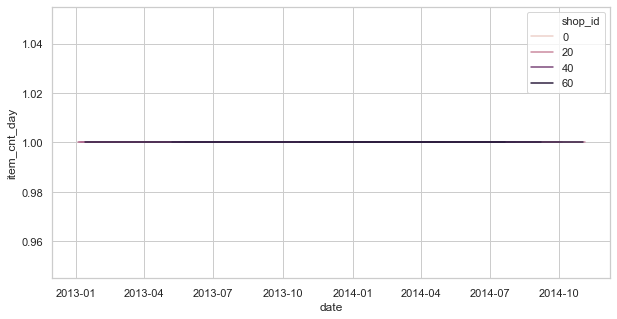

In [ ]:
data = train_ext[['date',
                  'item_id',
                  'shop_id',
                  'item_cnt_day']]

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y="item_cnt_day",
             hue="shop_id",
             data=data[data.item_id==55])
plt.show()

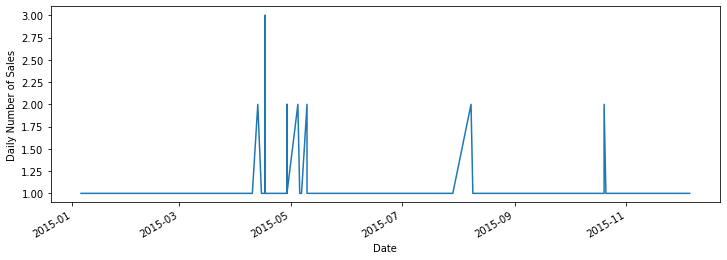

In [ ]:
# plot daily sales
ax = train_ext.set_index('date')[train_ext.set_index('date').item_id==70]['item_cnt_day'].plot(figsize = (12, 4),
                                                                                               )
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [ ]:
a = train_ext
a

3170       42
17143      42
122068     42
137122     42
153919     42
           ..
2630817    42
2682164    42
2772446    42
2857104    42
2897761    42
Name: item_id, Length: 109, dtype: int64

In [ ]:
item_cnt_mon = train_ext.groupby(['shop_id',
                                  'item_id',
                                  'date_block_num']).agg(
                                 #item_category_id=('item_category_id','min'),
                                 #item_price=('item_price', 'mean'),
                                 item_cnt_mon=('item_cnt_day', 'sum'),
                                 date=('date', 'max')
                                 #Month=('month', 'min'),
                                 #Year=('year', 'min'),
                                )

In [ ]:
item_cnt_mon = item_cnt_mon.reset_index()
item_cnt_mon

shop_id  item_id  date_block_num  item_cnt_mon       date
0              0       30               1          31.0 2013-02-26
1              0       31               1          11.0 2013-02-26
2              0       32               0           6.0 2013-03-01
3              0       32               1          10.0 2013-12-02
4              0       33               0           3.0 2013-03-01
...          ...      ...             ...           ...        ...
1609119       59    22164              27           2.0 2015-04-30
1609120       59    22164              30           1.0 2015-07-21
1609121       59    22167               9           1.0 2013-10-25
1609122       59    22167              11           2.0 2013-12-14
1609123       59    22167              17           1.0 2014-06-14

[1609124 rows x 5 columns]

In [ ]:
x = item_cnt_mon[(item_cnt_mon.shop_id==0) & (item_cnt_mon.item_id==30)]['date']
y = item_cnt_mon[(item_cnt_mon.item_id==30)]

In [ ]:
train_ext[(train_ext.item_id==30)]

date  date_block_num  shop_id  item_id  item_price  \
118406  2013-02-28               1       50       30       399.0   
118407  2013-02-26               1       50       30       399.0   
118419  2013-12-02               1       50       30       399.0   
118420  2013-02-14               1       50       30       399.0   
118421  2013-02-15               1       50       30       399.0   
...            ...             ...      ...      ...         ...   
2829959 2015-08-24              31       26       30       129.0   
2848217 2015-09-19              32       51       30        99.0   
2861850 2015-10-09              32        6       30       129.0   
2878415 2015-09-17              32       25       30       129.0   
2928372 2015-10-13              33       31       30       129.0   

         item_cnt_day  item_category_id  day  month  year  
118406            1.0                40   28      2  2013  
118407            1.0                40   26      2  2013  
118419            1.0                40    2     12  2013  
118420            2.0                40   14      2  2013  
118421            3.0                40   15      2  2013  
...               ...               ...  ...    ...   ...  
2829959           1.0                40   24      8  2015  
2848217           1.0                40   19      9  2015  
2861850           1.0                40    9     10  2015  
2878415           1.0                40   17      9  2015  
2928372           1.0                40   13     10  2015  

[1383 rows x 10 columns]

In [ ]:
y.head()

shop_id  item_id  date_block_num  item_cnt_mon       date
0           0       30               1          31.0 2013-02-26
4823        1       30               1          10.0 2013-02-26
8105        2       30               2           1.0 2013-01-03
8106        2       30               5           1.0 2013-06-16
8107        2       30              15           1.0 2014-04-20

In [ ]:
import matplotlib.pyplot as plt

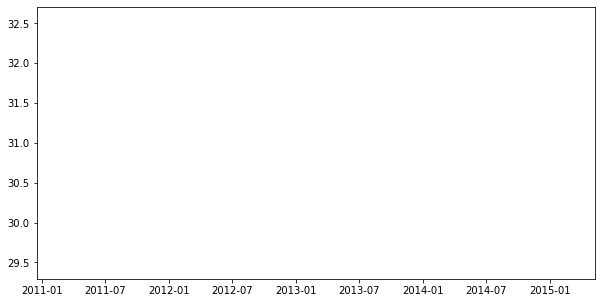

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(x,y)

## Building features for time series

In [ ]:
train_ext.loc[:,'date'] = pd.to_datetime(train_ext['date'])

In [ ]:
train_ext['date'].max() - train_ext['date'].min()

Timedelta('1073 days 00:00:00')

In [ ]:
train_ext['day'] = train_ext.date.apply(lambda df:df.day)
train_ext['month'] = train_ext.date.apply(lambda df:df.month)
train_ext['year'] = train_ext.date.apply(lambda df:df.year)

In [ ]:
train_ext.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154      999.00           1.0   
1 2013-03-01               0       25     2552      899.00           1.0   
2 2013-05-01               0       25     2552      899.00          -1.0   
3 2013-06-01               0       25     2554     1709.05           1.0   
4 2013-01-15               0       25     2555     1099.00           1.0   

   item_category_id  day  month  year  
0                37    1      2  2013  
1                58    1      3  2013  
2                58    1      5  2013  
3                58    1      6  2013  
4                56   15      1  2013

In [ ]:
# from sklearn.model_selection import train_test_split

I think the model will be more successful if it tries to predict for number of sales in 3 or more days(maybe <7) rather than trying to make daily predictions!

Let's try to prepare data for month prediction

In [ ]:
item_cnt_mon = train_ext.groupby(['shop_id',
                                  'item_id',
                                  'date_block_num']).agg(
                                item_category_id=('item_category_id','min'),
                                item_price=('item_price', 'mean'),
                                item_cnt_mon=('item_cnt_day', 'sum'),
                                Month=('month', 'min'),
                                Year=('year', 'min'),)

In [ ]:
item_cnt_mon

item_category_id  item_price  item_cnt_mon  \
shop_id item_id date_block_num                                               
0       30      1                             40       265.0          31.0   
        31      1                             37       434.0          11.0   
        32      0                             40       221.0           6.0   
                1                             40       221.0          10.0   
        33      0                             37       347.0           3.0   
...                                          ...         ...           ...   
59      22164   27                            37       699.0           2.0   
                30                            37       699.0           1.0   
        22167   9                             49       299.0           1.0   
                11                            49       299.0           2.0   
                17                            49       299.0           1.0   

                                Month  Year  
shop_id item_id date_block_num               
0       30      1                   2  2013  
        31      1                   2  2013  
        32      0                   1  2013  
                1                   2  2013  
        33      0                   1  2013  
...                               ...   ...  
59      22164   27                  4  2015  
                30                  7  2015  
        22167   9                  10  2013  
                11                  3  2013  
                17                  6  2014  

[1609124 rows x 5 columns]

In [ ]:
X_new = pd.DataFrame(item_cnt_mon).reset_index()
X_new

shop_id  item_id  date_block_num  item_category_id  item_price  \
0              0       30               1                40       265.0   
1              0       31               1                37       434.0   
2              0       32               0                40       221.0   
3              0       32               1                40       221.0   
4              0       33               0                37       347.0   
...          ...      ...             ...               ...         ...   
1609119       59    22164              27                37       699.0   
1609120       59    22164              30                37       699.0   
1609121       59    22167               9                49       299.0   
1609122       59    22167              11                49       299.0   
1609123       59    22167              17                49       299.0   

         item_cnt_mon  Month  Year  
0                31.0      2  2013  
1                11.0      2  2013  
2                 6.0      1  2013  
3                10.0      2  2013  
4                 3.0      1  2013  
...               ...    ...   ...  
1609119           2.0      4  2015  
1609120           1.0      7  2015  
1609121           1.0     10  2013  
1609122           2.0      3  2013  
1609123           1.0      6  2014  

[1609124 rows x 8 columns]

In [ ]:
train_ext.date_block_num.max()

33

In [ ]:
test_ext['date_block_num'] = 34

In [ ]:
train_ext.date.max()

Timestamp('2015-12-10 00:00:00')

In [ ]:
train_ext[(train_ext.year==2015) & (train_ext.month==12)].day.max()

10

In [ ]:
forcast_period = pd.date_range('2015-12-11', periods=31, freq='D')

DatetimeIndex(['2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14',
               '2015-12-15', '2015-12-16', '2015-12-17', '2015-12-18',
               '2015-12-19', '2015-12-20', '2015-12-21', '2015-12-22',
               '2015-12-23', '2015-12-24', '2015-12-25', '2015-12-26',
               '2015-12-27', '2015-12-28', '2015-12-29', '2015-12-30',
               '2015-12-31', '2016-01-01', '2016-01-02', '2016-01-03',
               '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-09', '2016-01-10'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
test_ext['date_block_num'] = 34
test_ext['date_block_num'] = 34

In [ ]:
y = X_new['item_cnt_mon']
X = X_new.drop('item_cnt_mon', axis=1)

In [ ]:
import xgboost as xgb


In [ ]:
dtrain = xgb.DMatrix(data=X, label=y)

In [ ]:
params = {'eval_metric': ['rmse', 'mae'],
          'learning_rate': 0.1,
          'max_depth': 12,
          'n_jobs': -1,
          'alpha': 1,
          'verbosity': 0,
          'min_child_weight': 1,
          'subsample': 0.9,
          'colsample_bytree': 0.9,
          'colsample_bylevel': 1,
          'tree_method': 'hist',
          'seed': 0,
          'disable_default_eval_metric': 1,
          #'num_parallel_tree': 20,
             }

In [ ]:
xgb.cv(params,
       dtrain,
       num_boost_round=1000,
       nfold=2,
       stratified=False,
       seed=0,
       shuffle=True,
       ).drop(['train-rmsle-std',
                'train-mae-std',
                'test-rmsle-std',
                'test-mae-std',
               ], axis=1).tail(5)

train-rmse-mean  train-rmse-std  train-mae-mean  test-rmse-mean  \
995         1.146052        0.065738        0.566187        5.301415   
996         1.145809        0.065963        0.566036        5.301416   
997         1.145263        0.065736        0.565806        5.301424   
998         1.144771        0.065697        0.565558        5.301447   
999         1.144380        0.065591        0.565409        5.301495   

     test-rmse-std  test-mae-mean  
995       0.525877       1.084606  
996       0.525850       1.084623  
997       0.525864       1.084662  
998       0.525833       1.084695  
999       0.525759       1.084728

In [ ]:
bst = xgb.train(params,
                    dtrain,
                    1000,
                    maximize=False,
                    verbose_eval =False,
                )

In [ ]:
bst.predict(xgb.DMatrix(X))

array([28.583517 ,  9.900044 ,  4.087884 , ...,  1.1939063,  2.2497623,
        0.8448132], dtype=float32)

In [ ]:
api.competition_submit('sample_submission.csv', '',
                       'competitive-data-science-predict-future-sales')

100%|██████████| 2.14M/2.14M [00:02<00:00, 1.07MB/s]


Successfully submitted to Predict Future Sales